# Configuration

In [1]:
import os
from tqdm.notebook import tqdm
from tqdm import tqdm
import librosa
import pandas as pd 
import pandas as np
from sklearn.metrics import classification_report

# Clean Data - Compute dataframes for datasets and split in Train, Val, Test 

In [2]:
main_path = '/Users/helemanc/Documents/MasterAI/THESIS/Datasets SER'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

## RAVDESS

In [3]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 283.84it/s]


In [4]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# merge neutral and calm
emotions_list = ['neutral', 'neutral', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [5]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [6]:
df.head()

,emotion,voc_channel,modality,intensity,actors,gender,phrase,path
0,angry,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,speech,audio only,normal,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [7]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [8]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [9]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [10]:
RAV_df

,emotion_label,actors,gender,path
0,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...,...
2869,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2871,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2872,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2873,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [11]:
RAV_train = []
RAV_val = []
RAV_test = []

In [12]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [13]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [14]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [15]:
RAV_train.reset_index(drop=True, inplace = True) 
RAV_val.reset_index(drop=True, inplace = True) 
RAV_test.reset_index(drop=True, inplace = True ) 

## SAVEE

In [16]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
disgust      60
angry        60
fear         60
surprise     60
happy        60
sadness      60
Name: emotion_label, dtype: int64

In [17]:
SAVEE_df.head()

,emotion_label,actors,gender,path
0,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,surprise,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [18]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [19]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [20]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [21]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

In [22]:
SAVEE_train = SAVEE_train.reset_index(drop=True) 
SAVEE_val = SAVEE_val.reset_index(drop=True) 
SAVEE_test = SAVEE_test.reset_index(drop=True) 

## TESS

In [23]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
sadness      800
neutral      800
fear         800
disgust      800
surprise     800
happy        400
Name: emotion_label, dtype: int64

In [24]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [25]:
TESS_train = []
TESS_test = []

In [26]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [27]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

In [28]:
TESS_train = TESS_train.drop(['actors'], 1)
TESS_test = TESS_test.drop(['actors'], 1)

In [29]:
TESS_train = TESS_train.reset_index(drop=True) 
TESS_test  = TESS_test.reset_index(drop=True) 

## CREMA-D

In [30]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [31]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [32]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,sadness,28,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,angry,48,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,disgust,27,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,disgust,32,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,happy,80,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [33]:
Crema_df.shape

(455, 4)

In [34]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [35]:
actor_files

{'28': 5,
 '48': 5,
 '27': 5,
 '32': 5,
 '80': 5,
 '59': 5,
 '39': 5,
 '43': 5,
 '56': 5,
 '31': 5,
 '24': 5,
 '51': 5,
 '44': 5,
 '77': 5,
 '62': 5,
 '88': 5,
 '55': 5,
 '40': 5,
 '13': 5,
 '06': 5,
 '35': 5,
 '20': 5,
 '87': 5,
 '09': 5,
 '78': 5,
 '65': 5,
 '70': 5,
 '23': 5,
 '36': 5,
 '01': 5,
 '14': 5,
 '47': 5,
 '52': 5,
 '58': 5,
 '37': 5,
 '22': 5,
 '71': 5,
 '64': 5,
 '50': 5,
 '45': 5,
 '57': 5,
 '42': 5,
 '29': 5,
 '53': 5,
 '46': 5,
 '33': 5,
 '26': 5,
 '34': 5,
 '21': 5,
 '15': 5,
 '08': 5,
 '86': 5,
 '79': 5,
 '63': 5,
 '76': 5,
 '25': 5,
 '30': 5,
 '07': 5,
 '12': 5,
 '41': 5,
 '54': 5,
 '89': 5,
 '81': 5,
 '49': 5,
 '38': 5,
 '05': 5,
 '10': 5,
 '61': 5,
 '74': 5,
 '69': 5,
 '18': 5,
 '83': 5,
 '17': 5,
 '02': 5,
 '73': 5,
 '66': 5,
 '84': 5,
 '91': 5,
 '90': 5,
 '85': 5,
 '03': 5,
 '16': 5,
 '67': 5,
 '72': 5,
 '68': 5,
 '82': 5,
 '19': 5,
 '11': 5,
 '04': 5,
 '75': 5,
 '60': 5}

In [36]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [37]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [38]:
import random 
'''
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove
'''
males_to_remove = ['17', '80', '88']

In [39]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [40]:
CREMA_df = pd.DataFrame(new_df)

In [41]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [42]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [43]:
count_males, count_females

(220, 220)

In [44]:
len(female_list)

44

In [45]:
len(male_list)

44

In [46]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [47]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [48]:
females_train, males_train, females_val, males_val, females_test, males_test

(['10',
  '78',
  '56',
  '73',
  '06',
  '60',
  '63',
  '54',
  '49',
  '46',
  '08',
  '89',
  '75',
  '52',
  '21',
  '40',
  '12',
  '25',
  '37',
  '30',
  '02',
  '43',
  '09',
  '55',
  '82',
  '58',
  '20',
  '13',
  '03',
  '29',
  '47',
  '91'],
 ['33',
  '81',
  '01',
  '34',
  '59',
  '51',
  '44',
  '11',
  '77',
  '65',
  '83',
  '42',
  '15',
  '69',
  '64',
  '35',
  '19',
  '16',
  '41',
  '48',
  '86',
  '62',
  '32',
  '38',
  '31',
  '22',
  '68',
  '87',
  '26',
  '39',
  '14',
  '85'],
 ['74', '28', '53', '72', '18', '84'],
 ['67', '71', '50', '66', '45', '05'],
 ['79', '76', '61', '07', '24', '04'],
 ['23', '90', '57', '70', '27', '36'])

In [49]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [50]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [51]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [52]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [53]:
CREMA_train = CREMA_train.drop(['actors'], 1)
CREMA_val = CREMA_val.drop(['actors'], 1)
CREMA_test = CREMA_test.drop(['actors'], 1)

In [54]:
CREMA_train = CREMA_train.reset_index(drop=True) 
CREMA_val = CREMA_val.reset_index(drop = True) 

# Create Validation Datasets Ensemble

- validation_dataset_1 = RAVDESS_clean_val + RAVDESS_clean_test 
- validation_dataset_2 = all_clean_val + all_clean_test

In [55]:
validation_dataset_1 = pd.concat([RAV_val, RAV_test], ignore_index=True, sort=False)

In [56]:
validation_dataset_1

,emotion_label,gender,path
0,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...
235,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
236,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
237,angry,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
238,surprise,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [57]:
validation_dataset_2 = pd.concat([RAV_val, RAV_test, 
                                    SAVEE_val, SAVEE_test, 
                                    TESS_test, 
                                    CREMA_val, CREMA_test], ignore_index=True, sort=False)

In [58]:
validation_dataset_2

,emotion_label,gender,path
0,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...
1995,disgust,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1996,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1997,sadness,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1998,happy,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


# Encode labels of Validation Datasets

In [59]:
labels_1 = list(validation_dataset_1.emotion_label)
labels_2 = list(validation_dataset_2.emotion_label)

In [60]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels_1 = pd.Series(labels_1).replace(emotion_enc)
labels_2 = pd.Series(labels_2).replace(emotion_enc)

# Utils Validation Ensemble

In [61]:
# import main
from inaSpeechSegmenter import Segmenter
from argparse import ArgumentParser
import utils
import warnings

In [62]:
# import utils
from speech_emotion_recognition import feature_extraction as fe, ensemble
import scipy
import numpy as np
from scipy import signal
from scipy.io.wavfile import write
from utils import resample, denoise

In [63]:
# other imports 
import sklearn
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [64]:
#!pip install scikit-learn==0.24.2

In [65]:
#!jupyter nbextension enable --py widgetsnbextension

In [66]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [67]:
def make_predictions(dataset, labels, prediction_scheme): 
    predictions = []
    model_predictions_list = []
    counter = 0
    for filepath in tqdm(dataset['path']):
        samples, sample_rate = fe.read_file(filepath)
        samples, sample_rate = resample(samples, sample_rate)
        new_samples = fe.cut_pad(samples)
        #new_filepath = "tmp.wav"
        final_prediction, model_predictions = ensemble.ensemble(new_samples, prediction_scheme, return_model_predictions = True)

        predictions.append(final_prediction)
        model_predictions_list.append(model_predictions) 
        print("True label", labels[counter], "Predicted label", predictions[counter])
        counter+=1
    return predictions, model_predictions_list

def create_dataframe_prediction_per_model(model_predictions_list):
    df_model_predictions = pd.DataFrame(model_predictions_list)
    df_model_predictions = df_model_predictions.reindex(sorted(df_model_predictions.columns), axis=1)
    return df_model_predictions
    
def create_dataframe_predictions(prediction_list):
    df_predictions = pd.DataFrame(prediction_list)
    return df_predictions

def create_dataframe_res(labels, df_predictions, df_model_predictions, dataset): 
    df_res = pd.concat([labels, 
                    df_predictions, 
                    df_model_predictions, 
                    dataset.path], axis = 1, ignore_index=True, sort=False)
    header_model_predictions = list(df_model_predictions.columns)
    new_header = []
    new_header.append('true_label')
    new_header.append('pred_label')
    new_header = new_header + header_model_predictions
    new_header.append('path')
    df_res.columns = new_header
    return df_res
    
def create_dataframes_false_positives_false_negatives(df_res): 
    misclassified_rows_false_positives = []
    misclassified_rows_false_negatives = []
    for index, row in df_res.iterrows():
        true = df_res.true_label[index]
        pred = df_res.pred_label[index]
        if true != pred: # store misclassified files
            if true ==1 and pred == 0: # disruptive classified as non-distruptive is false negative
                misclassified_rows_false_negatives.append(row)
            else:
                misclassified_rows_false_positives.append(row)  
    df_false_negatives = pd.DataFrame(misclassified_rows_false_negatives)
    df_false_negatives.reset_index(drop=True, inplace=True)

    df_false_positives = pd.DataFrame(misclassified_rows_false_positives)
    df_false_positives.reset_index(drop=True, inplace=True)
    
    return df_false_positives, df_false_negatives

def print_hist_models_predictions_fp(df_false_positives): 
    df_models_fp = df_false_positives.copy()
    df_models_fp.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fp.hist(figsize=(24,24))
    
def print_hist_models_predictions_fn(df_false_negatives): 
    df_models_fn = df_false_negatives.copy()
    df_models_fn.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fn.hist(figsize=(24,24))
    

    
    
    

# Validation 1 - RAVDESS

We use the same code of the main.py of the real application, without VAD module

In [68]:
predictions, model_prediction_list = make_predictions(validation_dataset_1, labels_1, prediction_scheme='majority')

  0%|          | 1/240 [00:15<1:03:13, 15.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  1%|          | 2/240 [00:29<59:57, 15.11s/it]  

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  1%|▏         | 3/240 [00:45<1:01:00, 15.45s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


  2%|▏         | 4/240 [01:00<1:00:02, 15.26s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  2%|▏         | 5/240 [01:13<57:26, 14.66s/it]  

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  2%|▎         | 6/240 [01:32<1:02:15, 15.97s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  3%|▎         | 7/240 [01:52<1:06:30, 17.12s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 1 Predicted label 0


  3%|▎         | 8/240 [02:10<1:07:15, 17.40s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  4%|▍         | 9/240 [02:28<1:07:36, 17.56s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


  4%|▍         | 10/240 [02:48<1:09:53, 18.23s/it]

[1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  5%|▍         | 11/240 [03:14<1:19:06, 20.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  5%|▌         | 12/240 [03:34<1:17:55, 20.51s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  5%|▌         | 13/240 [03:53<1:15:32, 19.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  6%|▌         | 14/240 [04:12<1:14:13, 19.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  6%|▋         | 15/240 [04:30<1:12:03, 19.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  7%|▋         | 16/240 [04:51<1:13:31, 19.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 17/240 [05:08<1:10:46, 19.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 18/240 [05:26<1:08:34, 18.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  8%|▊         | 19/240 [05:43<1:06:27, 18.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 20/240 [06:03<1:08:48, 18.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  9%|▉         | 21/240 [06:25<1:11:58, 19.72s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 22/240 [06:45<1:11:30, 19.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 10%|▉         | 23/240 [07:23<1:30:55, 25.14s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 10%|█         | 24/240 [07:43<1:25:30, 23.75s/it]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 10%|█         | 25/240 [08:05<1:23:06, 23.19s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 11%|█         | 26/240 [08:21<1:14:50, 20.98s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 11%|█▏        | 27/240 [08:35<1:07:19, 18.96s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 12%|█▏        | 28/240 [08:51<1:04:12, 18.17s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 12%|█▏        | 29/240 [09:13<1:07:08, 19.09s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 12%|█▎        | 30/240 [09:30<1:04:34, 18.45s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


 13%|█▎        | 31/240 [09:53<1:09:31, 19.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 13%|█▎        | 32/240 [10:20<1:16:19, 22.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 14%|█▍        | 33/240 [10:46<1:20:15, 23.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 14%|█▍        | 34/240 [11:11<1:22:04, 23.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 15%|█▍        | 35/240 [11:47<1:33:32, 27.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 15%|█▌        | 36/240 [12:06<1:24:27, 24.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 15%|█▌        | 37/240 [12:24<1:17:47, 22.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 16%|█▌        | 38/240 [12:41<1:11:07, 21.12s/it]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 16%|█▋        | 39/240 [12:59<1:07:06, 20.03s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


 17%|█▋        | 40/240 [13:22<1:09:49, 20.95s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 17%|█▋        | 41/240 [13:39<1:06:07, 19.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 0


 18%|█▊        | 42/240 [13:56<1:02:48, 19.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 18%|█▊        | 43/240 [14:12<59:29, 18.12s/it]  

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 18%|█▊        | 44/240 [14:29<57:20, 17.56s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 19%|█▉        | 45/240 [14:43<53:57, 16.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 19%|█▉        | 46/240 [15:06<1:00:05, 18.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 20%|█▉        | 47/240 [15:35<1:09:43, 21.68s/it]

[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 20%|██        | 48/240 [15:52<1:04:58, 20.31s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 20%|██        | 49/240 [16:09<1:01:21, 19.27s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 21%|██        | 50/240 [16:26<58:46, 18.56s/it]  

[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 21%|██▏       | 51/240 [16:42<56:02, 17.79s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 22%|██▏       | 52/240 [16:58<53:50, 17.18s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 22%|██▏       | 53/240 [17:20<58:04, 18.63s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 22%|██▎       | 54/240 [17:40<59:42, 19.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 23%|██▎       | 55/240 [18:01<1:00:15, 19.54s/it]

[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 23%|██▎       | 56/240 [18:21<1:00:17, 19.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 24%|██▍       | 57/240 [18:41<1:01:05, 20.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 24%|██▍       | 58/240 [19:05<1:04:04, 21.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 25%|██▍       | 59/240 [19:28<1:05:08, 21.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 25%|██▌       | 60/240 [19:48<1:03:26, 21.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 25%|██▌       | 61/240 [20:08<1:02:36, 20.99s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 26%|██▌       | 62/240 [20:38<1:09:31, 23.43s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▋       | 63/240 [20:58<1:06:15, 22.46s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 27%|██▋       | 64/240 [21:20<1:05:51, 22.45s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 27%|██▋       | 65/240 [21:44<1:06:23, 22.76s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 28%|██▊       | 66/240 [22:05<1:04:22, 22.20s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 28%|██▊       | 67/240 [22:30<1:06:53, 23.20s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 28%|██▊       | 68/240 [22:52<1:05:40, 22.91s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 29%|██▉       | 69/240 [23:18<1:07:32, 23.70s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 29%|██▉       | 70/240 [23:45<1:09:35, 24.56s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 30%|██▉       | 71/240 [24:09<1:09:14, 24.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 30%|███       | 72/240 [24:29<1:04:38, 23.09s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 30%|███       | 73/240 [24:48<1:01:27, 22.08s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 1


 31%|███       | 74/240 [25:09<1:00:07, 21.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 31%|███▏      | 75/240 [25:43<1:09:12, 25.16s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 32%|███▏      | 76/240 [26:04<1:05:27, 23.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 32%|███▏      | 77/240 [26:24<1:02:10, 22.89s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 32%|███▎      | 78/240 [26:45<59:47, 22.15s/it]  

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 33%|███▎      | 79/240 [27:10<1:01:50, 23.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 33%|███▎      | 80/240 [27:26<55:48, 20.93s/it]  

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 34%|███▍      | 81/240 [27:47<55:34, 20.97s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 34%|███▍      | 82/240 [28:10<57:09, 21.70s/it]

[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 35%|███▍      | 83/240 [28:35<59:06, 22.59s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 35%|███▌      | 84/240 [28:59<1:00:22, 23.22s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 35%|███▌      | 85/240 [29:22<59:07, 22.89s/it]  

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 36%|███▌      | 86/240 [29:39<54:37, 21.28s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 1


 36%|███▋      | 87/240 [30:03<56:02, 21.98s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 37%|███▋      | 88/240 [30:33<1:02:02, 24.49s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 37%|███▋      | 89/240 [30:51<56:19, 22.38s/it]  

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 90/240 [31:09<53:21, 21.35s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 91/240 [31:31<53:25, 21.51s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 38%|███▊      | 92/240 [31:53<53:23, 21.64s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 39%|███▉      | 93/240 [32:09<48:17, 19.71s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 39%|███▉      | 94/240 [32:24<45:09, 18.56s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 40%|███▉      | 95/240 [32:40<42:34, 17.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 40%|████      | 96/240 [32:55<40:29, 16.87s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 40%|████      | 97/240 [33:11<39:54, 16.75s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


 41%|████      | 98/240 [33:27<39:08, 16.54s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 41%|████▏     | 99/240 [33:42<37:36, 16.00s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


 42%|████▏     | 100/240 [34:00<38:19, 16.42s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 42%|████▏     | 101/240 [34:15<37:35, 16.23s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 42%|████▎     | 102/240 [34:30<36:19, 15.79s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 43%|████▎     | 103/240 [34:45<35:40, 15.62s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 43%|████▎     | 104/240 [35:01<35:21, 15.60s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 44%|████▍     | 105/240 [35:17<35:12, 15.65s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 44%|████▍     | 106/240 [35:37<37:53, 16.97s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 45%|████▍     | 107/240 [36:01<42:36, 19.22s/it]

[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 45%|████▌     | 108/240 [36:27<46:52, 21.31s/it]

[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


 45%|████▌     | 109/240 [36:48<46:05, 21.11s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


 46%|████▌     | 110/240 [37:03<41:44, 19.27s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 46%|████▋     | 111/240 [37:18<38:54, 18.09s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 47%|████▋     | 112/240 [37:34<37:12, 17.44s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 47%|████▋     | 113/240 [37:51<36:38, 17.31s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 48%|████▊     | 114/240 [38:07<35:07, 16.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 48%|████▊     | 115/240 [38:22<34:07, 16.38s/it]

[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 48%|████▊     | 116/240 [38:38<33:29, 16.20s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 49%|████▉     | 117/240 [38:55<33:45, 16.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 49%|████▉     | 118/240 [39:12<33:28, 16.46s/it]

[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 50%|████▉     | 119/240 [39:29<33:33, 16.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 50%|█████     | 120/240 [39:44<32:36, 16.31s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 50%|█████     | 121/240 [40:02<33:02, 16.66s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 51%|█████     | 122/240 [40:17<32:12, 16.38s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


 51%|█████▏    | 123/240 [40:35<32:40, 16.76s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 52%|█████▏    | 124/240 [40:52<32:23, 16.75s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 52%|█████▏    | 125/240 [41:08<31:45, 16.57s/it]

[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 52%|█████▎    | 126/240 [41:24<31:10, 16.40s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 53%|█████▎    | 127/240 [41:39<30:23, 16.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 53%|█████▎    | 128/240 [41:55<29:48, 15.97s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 54%|█████▍    | 129/240 [42:13<30:43, 16.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 54%|█████▍    | 130/240 [42:32<31:28, 17.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 55%|█████▍    | 131/240 [42:50<32:08, 17.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 55%|█████▌    | 132/240 [43:07<31:25, 17.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 55%|█████▌    | 133/240 [43:24<30:48, 17.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 56%|█████▌    | 134/240 [43:40<29:53, 16.92s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 56%|█████▋    | 135/240 [43:56<29:10, 16.67s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 57%|█████▋    | 136/240 [44:12<28:27, 16.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 57%|█████▋    | 137/240 [44:33<30:11, 17.59s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 57%|█████▊    | 138/240 [44:50<29:51, 17.56s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 58%|█████▊    | 139/240 [45:09<30:17, 18.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 58%|█████▊    | 140/240 [45:26<29:26, 17.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 59%|█████▉    | 141/240 [45:45<29:35, 17.94s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 59%|█████▉    | 142/240 [46:03<29:36, 18.13s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 60%|█████▉    | 143/240 [46:21<29:14, 18.09s/it]

[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 60%|██████    | 144/240 [46:37<28:07, 17.58s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 60%|██████    | 145/240 [46:55<27:50, 17.58s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 61%|██████    | 146/240 [47:12<27:25, 17.51s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 61%|██████▏   | 147/240 [47:28<26:27, 17.07s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 62%|██████▏   | 148/240 [47:49<27:58, 18.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 62%|██████▏   | 149/240 [48:08<27:56, 18.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 62%|██████▎   | 150/240 [48:29<28:34, 19.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 63%|██████▎   | 151/240 [48:50<29:04, 19.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 63%|██████▎   | 152/240 [49:08<28:16, 19.28s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 64%|██████▍   | 153/240 [49:23<26:00, 17.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 64%|██████▍   | 154/240 [49:41<25:33, 17.83s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 65%|██████▍   | 155/240 [50:03<27:11, 19.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 65%|██████▌   | 156/240 [50:29<29:49, 21.30s/it]

[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 65%|██████▌   | 157/240 [50:46<27:28, 19.86s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 66%|██████▌   | 158/240 [51:02<25:36, 18.74s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 66%|██████▋   | 159/240 [51:18<24:14, 17.96s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 67%|██████▋   | 160/240 [51:33<22:43, 17.05s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 67%|██████▋   | 161/240 [51:49<22:02, 16.74s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 68%|██████▊   | 162/240 [52:04<21:03, 16.21s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 68%|██████▊   | 163/240 [52:19<20:18, 15.83s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 68%|██████▊   | 164/240 [52:37<20:48, 16.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 69%|██████▉   | 165/240 [52:53<20:21, 16.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 69%|██████▉   | 166/240 [53:09<19:59, 16.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 70%|██████▉   | 167/240 [53:31<21:54, 18.00s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 70%|███████   | 168/240 [53:47<20:54, 17.43s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 70%|███████   | 169/240 [54:06<21:24, 18.09s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 71%|███████   | 170/240 [54:29<22:38, 19.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 71%|███████▏  | 171/240 [54:46<21:24, 18.62s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 72%|███████▏  | 172/240 [55:04<21:01, 18.56s/it]

[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 72%|███████▏  | 173/240 [55:23<20:54, 18.72s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 1


 72%|███████▎  | 174/240 [55:39<19:33, 17.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 73%|███████▎  | 175/240 [55:58<19:46, 18.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 73%|███████▎  | 176/240 [56:18<20:05, 18.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 74%|███████▍  | 177/240 [56:35<19:01, 18.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 74%|███████▍  | 178/240 [56:55<19:23, 18.77s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 75%|███████▍  | 179/240 [57:14<18:58, 18.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 75%|███████▌  | 180/240 [57:31<18:14, 18.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 75%|███████▌  | 181/240 [57:47<17:17, 17.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 76%|███████▌  | 182/240 [58:03<16:33, 17.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 76%|███████▋  | 183/240 [58:18<15:42, 16.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 77%|███████▋  | 184/240 [58:33<15:01, 16.09s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 77%|███████▋  | 185/240 [58:50<14:52, 16.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 78%|███████▊  | 186/240 [59:05<14:25, 16.02s/it]

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 78%|███████▊  | 187/240 [59:20<13:46, 15.59s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 78%|███████▊  | 188/240 [59:42<15:15, 17.61s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 79%|███████▉  | 189/240 [1:00:01<15:17, 18.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 79%|███████▉  | 190/240 [1:00:18<14:37, 17.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 80%|███████▉  | 191/240 [1:00:35<14:16, 17.47s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 80%|████████  | 192/240 [1:00:53<14:13, 17.78s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 80%|████████  | 193/240 [1:01:11<13:55, 17.77s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 81%|████████  | 194/240 [1:01:33<14:38, 19.09s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 1


 81%|████████▏ | 195/240 [1:02:02<16:30, 22.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 82%|████████▏ | 196/240 [1:02:20<15:14, 20.79s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 82%|████████▏ | 197/240 [1:02:38<14:23, 20.07s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 82%|████████▎ | 198/240 [1:02:58<13:57, 19.95s/it]

[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 83%|████████▎ | 199/240 [1:03:16<13:18, 19.48s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 83%|████████▎ | 200/240 [1:03:36<12:59, 19.50s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 84%|████████▍ | 201/240 [1:03:52<12:00, 18.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 84%|████████▍ | 202/240 [1:04:08<11:08, 17.59s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 85%|████████▍ | 203/240 [1:04:26<10:55, 17.71s/it]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 85%|████████▌ | 204/240 [1:04:47<11:21, 18.93s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 85%|████████▌ | 205/240 [1:05:07<11:05, 19.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 86%|████████▌ | 206/240 [1:05:26<10:52, 19.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▋ | 207/240 [1:05:46<10:44, 19.53s/it]

[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 208/240 [1:06:06<10:20, 19.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 87%|████████▋ | 209/240 [1:06:27<10:18, 19.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 210/240 [1:06:50<10:23, 20.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 88%|████████▊ | 211/240 [1:07:08<09:40, 20.01s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 88%|████████▊ | 212/240 [1:07:26<09:02, 19.38s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 89%|████████▉ | 213/240 [1:07:42<08:21, 18.56s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 89%|████████▉ | 214/240 [1:07:58<07:39, 17.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 90%|████████▉ | 215/240 [1:08:13<07:05, 17.00s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 90%|█████████ | 216/240 [1:08:29<06:41, 16.73s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 90%|█████████ | 217/240 [1:08:45<06:17, 16.42s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 91%|█████████ | 218/240 [1:09:00<05:52, 16.03s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 91%|█████████▏| 219/240 [1:09:17<05:41, 16.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 92%|█████████▏| 220/240 [1:09:36<05:38, 16.93s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 1


 92%|█████████▏| 221/240 [1:09:53<05:23, 17.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▎| 222/240 [1:10:18<05:52, 19.59s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 93%|█████████▎| 223/240 [1:10:48<06:23, 22.53s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 93%|█████████▎| 224/240 [1:11:22<06:56, 26.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 94%|█████████▍| 225/240 [1:11:45<06:15, 25.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 94%|█████████▍| 226/240 [1:12:11<05:57, 25.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 95%|█████████▍| 227/240 [1:12:32<05:14, 24.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 95%|█████████▌| 228/240 [1:12:51<04:28, 22.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 95%|█████████▌| 229/240 [1:13:08<03:49, 20.83s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 96%|█████████▌| 230/240 [1:13:26<03:19, 19.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 96%|█████████▋| 231/240 [1:13:44<02:54, 19.42s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 97%|█████████▋| 232/240 [1:14:01<02:29, 18.65s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 97%|█████████▋| 233/240 [1:14:16<02:04, 17.74s/it]

[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 98%|█████████▊| 234/240 [1:14:33<01:44, 17.39s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 235/240 [1:14:49<01:24, 16.89s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 98%|█████████▊| 236/240 [1:15:05<01:07, 16.82s/it]

[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 99%|█████████▉| 237/240 [1:15:22<00:50, 16.84s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 99%|█████████▉| 238/240 [1:15:42<00:35, 17.85s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


100%|█████████▉| 239/240 [1:16:00<00:17, 17.76s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


100%|██████████| 240/240 [1:16:21<00:00, 19.09s/it]

[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


In [69]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels_1, df_predictions, df_model_predictions, validation_dataset_1)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

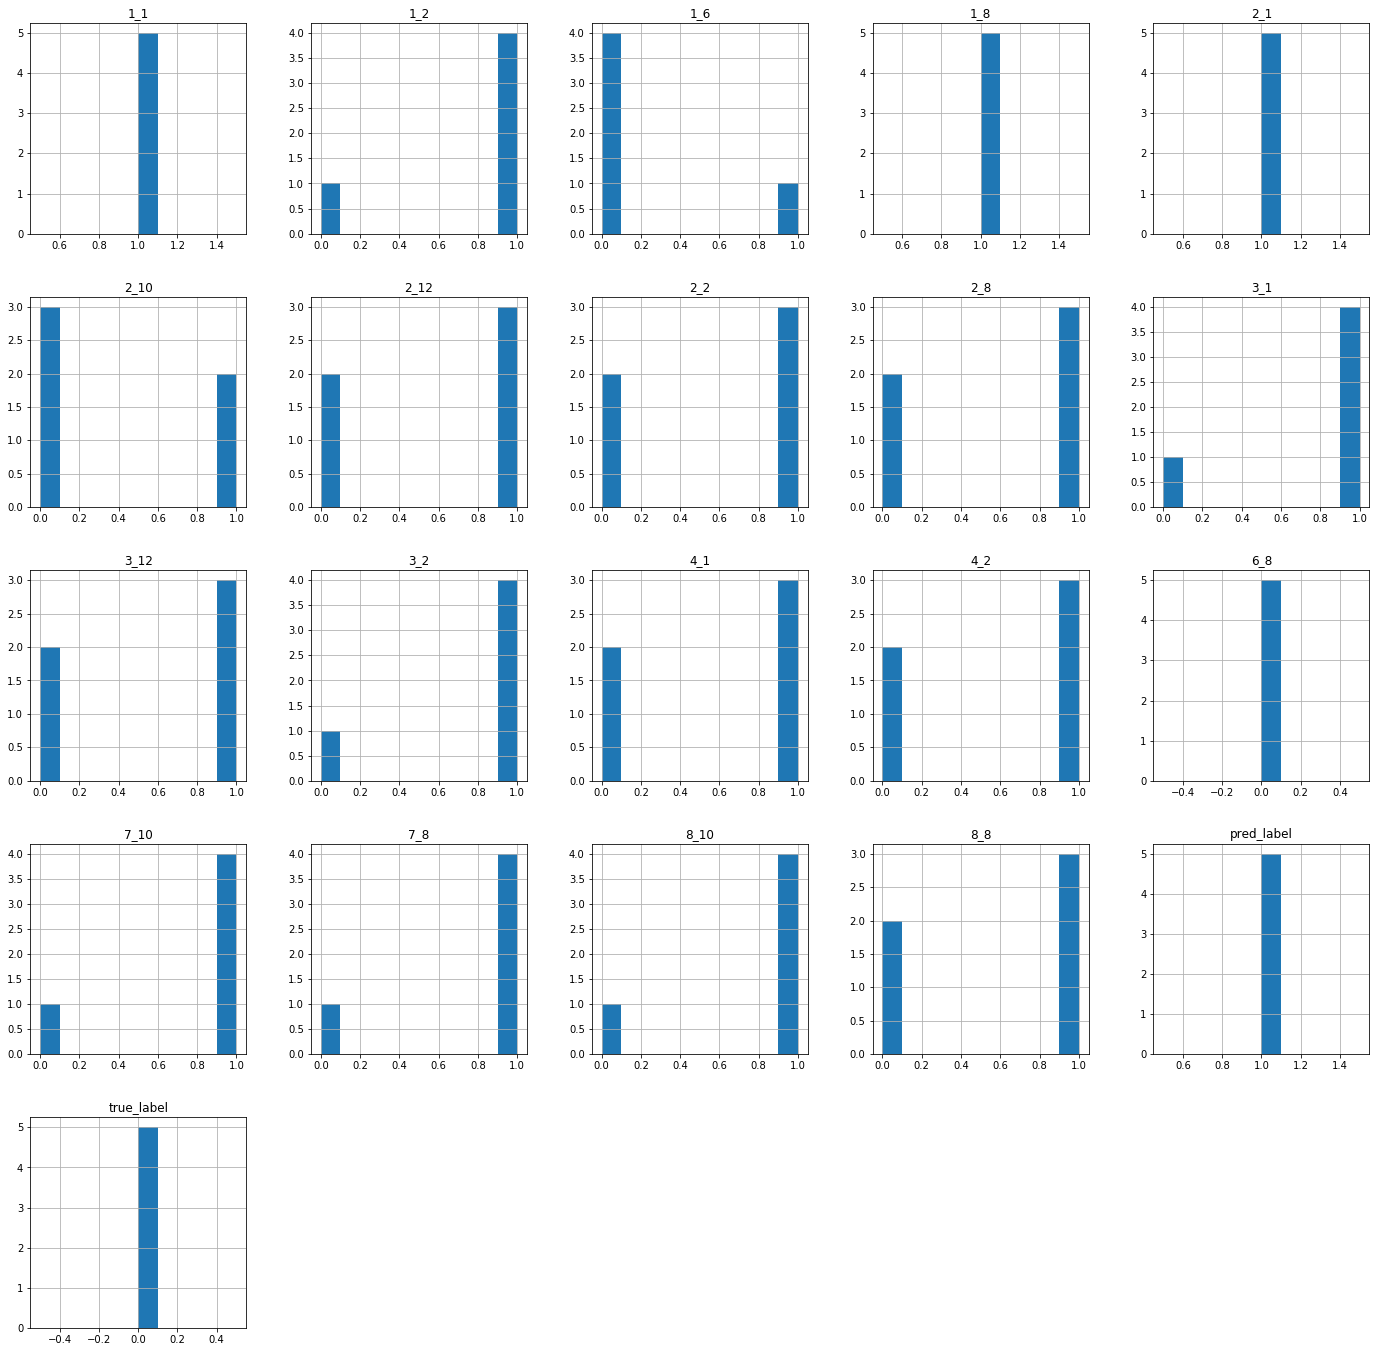

In [70]:
print_hist_models_predictions_fp(df_fp)

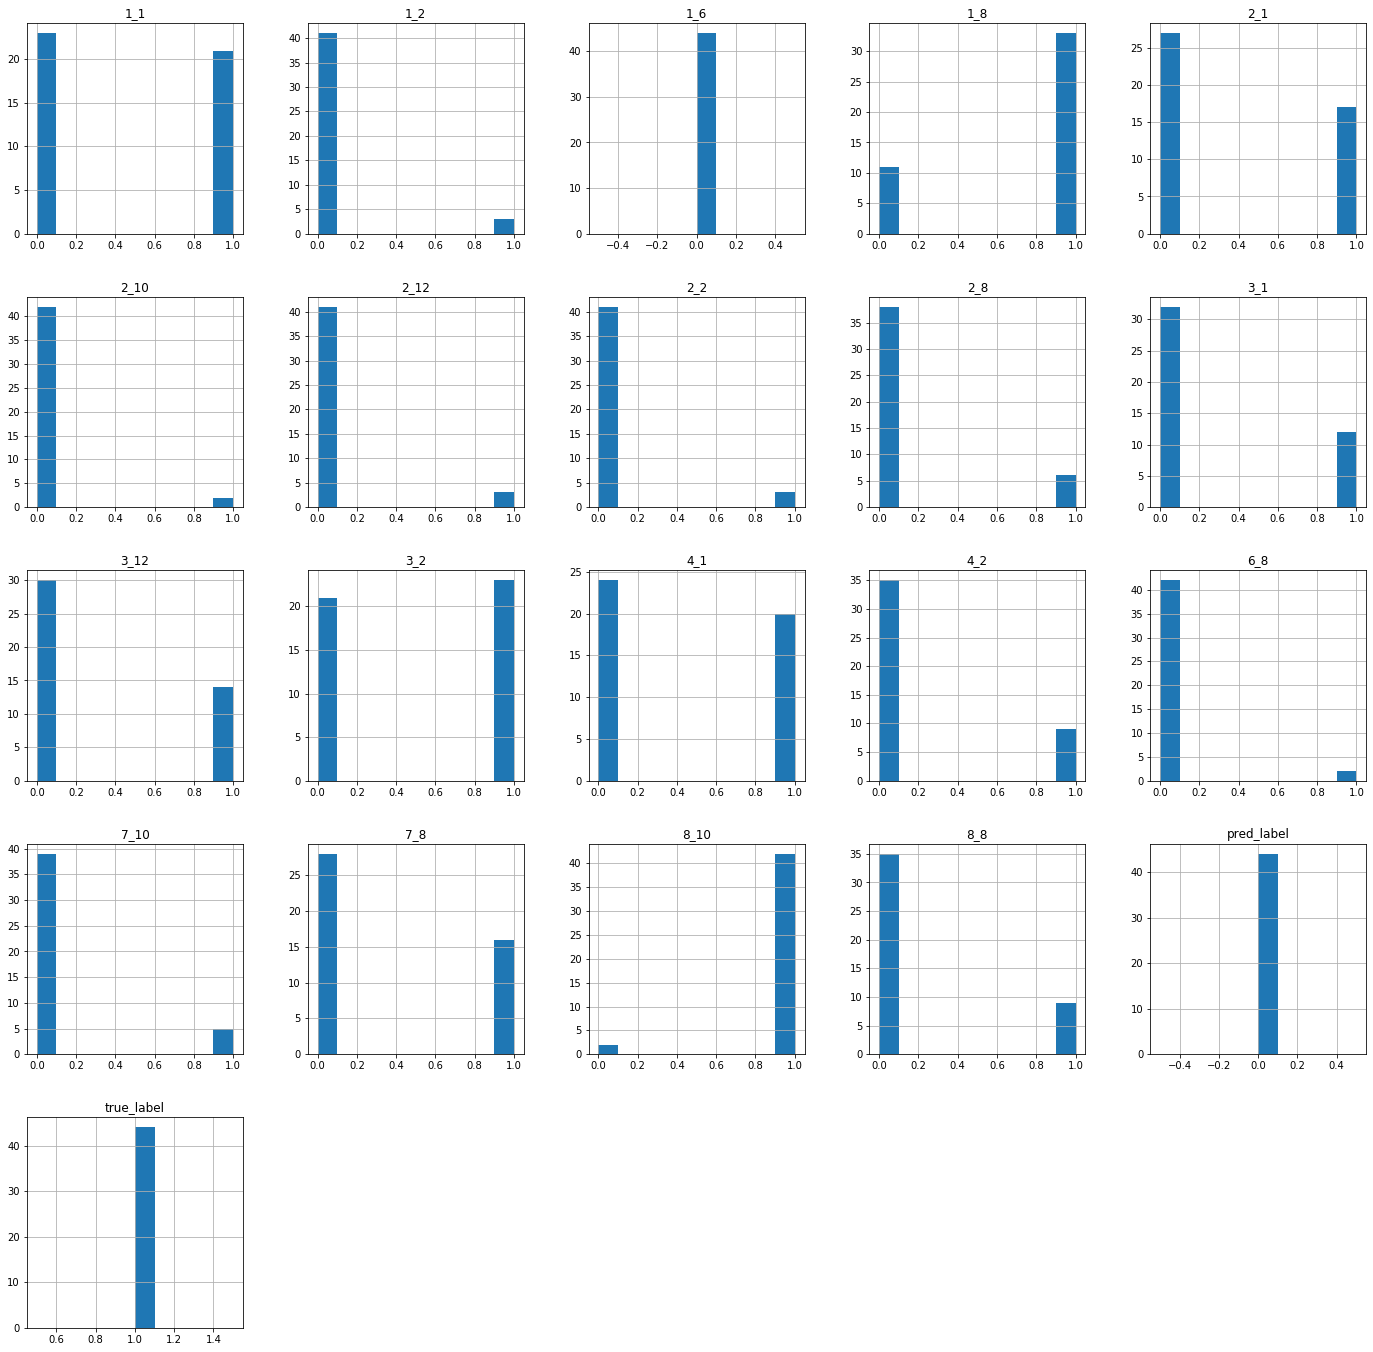

In [71]:
print_hist_models_predictions_fn(df_fn)

In [72]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.71      0.96      0.81       112
           1       0.94      0.66      0.77       128

    accuracy                           0.80       240
   macro avg       0.83      0.81      0.79       240
weighted avg       0.83      0.80      0.79       240



In [73]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/majority_validation_1_threhsold_0.7.csv"
df_res.to_csv(csv_path)

# Validation 2 - ALL DATASETS

We use the same code of the main.py of the real application, without VAD module

In [74]:
predictions, model_prediction_list = make_predictions(validation_dataset_2, labels_2, prediction_scheme='majority')

  0%|          | 1/2000 [00:19<10:46:36, 19.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  0%|          | 2/2000 [00:38<10:40:00, 19.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  0%|          | 3/2000 [01:00<11:06:22, 20.02s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


  0%|          | 4/2000 [01:22<11:29:13, 20.72s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  0%|          | 5/2000 [01:42<11:21:41, 20.50s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  0%|          | 6/2000 [02:01<11:07:00, 20.07s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  0%|          | 7/2000 [02:20<10:55:23, 19.73s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 1 Predicted label 0


  0%|          | 8/2000 [02:38<10:39:09, 19.25s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  0%|          | 9/2000 [02:59<10:53:33, 19.70s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


  0%|          | 10/2000 [03:22<11:28:07, 20.75s/it]

[1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  1%|          | 11/2000 [03:42<11:24:06, 20.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  1%|          | 12/2000 [04:02<11:12:08, 20.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  1%|          | 13/2000 [04:22<11:12:43, 20.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  1%|          | 14/2000 [04:43<11:13:33, 20.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  1%|          | 15/2000 [05:11<12:29:26, 22.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  1%|          | 16/2000 [05:28<11:34:58, 21.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  1%|          | 17/2000 [05:43<10:39:25, 19.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  1%|          | 18/2000 [05:59<10:00:02, 18.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  1%|          | 19/2000 [06:18<10:08:14, 18.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  1%|          | 20/2000 [06:42<11:01:50, 20.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  1%|          | 21/2000 [06:57<10:18:12, 18.74s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  1%|          | 22/2000 [07:19<10:48:53, 19.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  1%|          | 23/2000 [07:43<11:30:45, 20.96s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  1%|          | 24/2000 [08:08<12:08:55, 22.13s/it]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  1%|▏         | 25/2000 [08:29<11:59:30, 21.86s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  1%|▏         | 26/2000 [08:47<11:18:41, 20.63s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


  1%|▏         | 27/2000 [09:05<10:48:35, 19.72s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  1%|▏         | 28/2000 [09:26<11:03:41, 20.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


  1%|▏         | 29/2000 [09:49<11:33:27, 21.11s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  2%|▏         | 30/2000 [10:09<11:24:29, 20.85s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


  2%|▏         | 31/2000 [10:33<11:54:28, 21.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  2%|▏         | 32/2000 [10:57<12:12:54, 22.34s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  2%|▏         | 33/2000 [11:14<11:23:20, 20.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  2%|▏         | 34/2000 [11:32<10:52:39, 19.92s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  2%|▏         | 35/2000 [11:48<10:10:34, 18.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  2%|▏         | 36/2000 [12:03<9:36:28, 17.61s/it] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  2%|▏         | 37/2000 [12:19<9:18:31, 17.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  2%|▏         | 38/2000 [12:34<9:00:50, 16.54s/it]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  2%|▏         | 39/2000 [12:49<8:44:31, 16.05s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


  2%|▏         | 40/2000 [13:04<8:35:44, 15.79s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  2%|▏         | 41/2000 [13:20<8:39:26, 15.91s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 0


  2%|▏         | 42/2000 [13:37<8:51:12, 16.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  2%|▏         | 43/2000 [13:52<8:37:28, 15.87s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  2%|▏         | 44/2000 [14:08<8:34:20, 15.78s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  2%|▏         | 45/2000 [14:23<8:30:18, 15.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


  2%|▏         | 46/2000 [14:39<8:26:50, 15.56s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  2%|▏         | 47/2000 [14:54<8:24:08, 15.49s/it]

[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  2%|▏         | 48/2000 [15:09<8:24:07, 15.50s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  2%|▏         | 49/2000 [15:25<8:28:49, 15.65s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  2%|▎         | 50/2000 [15:41<8:25:45, 15.56s/it]

[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  3%|▎         | 51/2000 [15:58<8:39:15, 15.99s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  3%|▎         | 52/2000 [16:14<8:44:53, 16.17s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  3%|▎         | 53/2000 [16:29<8:32:56, 15.81s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  3%|▎         | 54/2000 [16:45<8:32:25, 15.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


  3%|▎         | 55/2000 [17:01<8:36:17, 15.93s/it]

[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  3%|▎         | 56/2000 [17:17<8:29:32, 15.73s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  3%|▎         | 57/2000 [17:33<8:34:47, 15.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  3%|▎         | 58/2000 [17:49<8:32:33, 15.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  3%|▎         | 59/2000 [18:04<8:29:40, 15.75s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  3%|▎         | 60/2000 [18:19<8:18:02, 15.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  3%|▎         | 61/2000 [18:35<8:28:32, 15.74s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  3%|▎         | 62/2000 [18:50<8:22:28, 15.56s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


  3%|▎         | 63/2000 [19:05<8:17:11, 15.40s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  3%|▎         | 64/2000 [19:21<8:15:35, 15.36s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  3%|▎         | 65/2000 [19:38<8:36:00, 16.00s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  3%|▎         | 66/2000 [19:54<8:34:56, 15.98s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


  3%|▎         | 67/2000 [20:09<8:21:16, 15.56s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  3%|▎         | 68/2000 [20:24<8:22:38, 15.61s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


  3%|▎         | 69/2000 [20:40<8:18:50, 15.50s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  4%|▎         | 70/2000 [20:55<8:16:42, 15.44s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  4%|▎         | 71/2000 [21:11<8:19:03, 15.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  4%|▎         | 72/2000 [21:26<8:14:36, 15.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  4%|▎         | 73/2000 [21:43<8:28:33, 15.83s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 1


  4%|▎         | 74/2000 [21:58<8:18:51, 15.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  4%|▍         | 75/2000 [22:13<8:19:22, 15.56s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


  4%|▍         | 76/2000 [22:29<8:19:00, 15.56s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  4%|▍         | 77/2000 [22:43<8:11:12, 15.33s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  4%|▍         | 78/2000 [22:59<8:13:38, 15.41s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


  4%|▍         | 79/2000 [23:14<8:10:25, 15.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  4%|▍         | 80/2000 [23:30<8:18:34, 15.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  4%|▍         | 81/2000 [23:46<8:19:29, 15.62s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  4%|▍         | 82/2000 [24:02<8:18:53, 15.61s/it]

[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  4%|▍         | 83/2000 [24:17<8:18:35, 15.61s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


  4%|▍         | 84/2000 [24:32<8:06:48, 15.24s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  4%|▍         | 85/2000 [24:48<8:16:03, 15.54s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  4%|▍         | 86/2000 [25:03<8:14:19, 15.50s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 1


  4%|▍         | 87/2000 [25:19<8:14:42, 15.52s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  4%|▍         | 88/2000 [25:34<8:11:42, 15.43s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  4%|▍         | 89/2000 [25:50<8:19:03, 15.67s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  4%|▍         | 90/2000 [26:06<8:18:45, 15.67s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  5%|▍         | 91/2000 [26:20<8:07:07, 15.31s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


  5%|▍         | 92/2000 [26:37<8:15:08, 15.57s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


  5%|▍         | 93/2000 [26:52<8:16:02, 15.61s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


  5%|▍         | 94/2000 [27:08<8:11:52, 15.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  5%|▍         | 95/2000 [27:23<8:08:17, 15.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  5%|▍         | 96/2000 [27:38<8:07:06, 15.35s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


  5%|▍         | 97/2000 [27:59<9:02:08, 17.09s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


  5%|▍         | 98/2000 [28:14<8:44:01, 16.53s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


  5%|▍         | 99/2000 [28:30<8:34:35, 16.24s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


  5%|▌         | 100/2000 [28:46<8:30:34, 16.12s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  5%|▌         | 101/2000 [29:02<8:28:26, 16.06s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  5%|▌         | 102/2000 [29:18<8:26:12, 16.00s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  5%|▌         | 103/2000 [29:32<8:13:39, 15.61s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  5%|▌         | 104/2000 [29:49<8:20:17, 15.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  5%|▌         | 105/2000 [30:06<8:30:31, 16.16s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  5%|▌         | 106/2000 [30:21<8:21:07, 15.88s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  5%|▌         | 107/2000 [30:36<8:12:44, 15.62s/it]

[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


  5%|▌         | 108/2000 [30:51<8:10:20, 15.55s/it]

[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


  5%|▌         | 109/2000 [31:07<8:10:21, 15.56s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


  6%|▌         | 110/2000 [31:22<8:05:54, 15.43s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  6%|▌         | 111/2000 [31:37<8:06:11, 15.44s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  6%|▌         | 112/2000 [31:53<8:08:27, 15.52s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


  6%|▌         | 113/2000 [32:09<8:11:47, 15.64s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


  6%|▌         | 114/2000 [32:25<8:14:08, 15.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  6%|▌         | 115/2000 [32:40<8:10:23, 15.61s/it]

[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  6%|▌         | 116/2000 [32:56<8:08:09, 15.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


  6%|▌         | 117/2000 [33:10<8:01:04, 15.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


  6%|▌         | 118/2000 [33:26<8:07:51, 15.55s/it]

[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


  6%|▌         | 119/2000 [33:42<8:07:49, 15.56s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  6%|▌         | 120/2000 [33:58<8:08:39, 15.60s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


  6%|▌         | 121/2000 [34:14<8:13:55, 15.77s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  6%|▌         | 122/2000 [34:30<8:12:14, 15.73s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1


  6%|▌         | 123/2000 [34:45<8:11:23, 15.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  6%|▌         | 124/2000 [35:00<8:03:24, 15.46s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  6%|▋         | 125/2000 [35:15<7:59:57, 15.36s/it]

[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  6%|▋         | 126/2000 [35:31<8:00:51, 15.40s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  6%|▋         | 127/2000 [35:46<8:02:02, 15.44s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  6%|▋         | 128/2000 [36:01<7:51:30, 15.11s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  6%|▋         | 129/2000 [36:20<8:34:12, 16.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  6%|▋         | 130/2000 [36:39<8:56:44, 17.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 131/2000 [36:56<8:56:10, 17.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 132/2000 [37:11<8:32:22, 16.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 133/2000 [37:31<9:03:48, 17.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 134/2000 [37:48<8:55:05, 17.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 135/2000 [38:04<8:50:13, 17.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 136/2000 [38:23<9:02:02, 17.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 137/2000 [38:42<9:15:46, 17.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 138/2000 [39:00<9:24:15, 18.18s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 139/2000 [39:16<8:58:27, 17.36s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 140/2000 [39:31<8:35:41, 16.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  7%|▋         | 141/2000 [39:47<8:32:21, 16.54s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  7%|▋         | 142/2000 [40:02<8:13:24, 15.93s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  7%|▋         | 143/2000 [40:19<8:29:40, 16.47s/it]

[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  7%|▋         | 144/2000 [40:35<8:23:01, 16.26s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  7%|▋         | 145/2000 [40:53<8:37:23, 16.73s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  7%|▋         | 146/2000 [41:12<9:01:52, 17.54s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


  7%|▋         | 147/2000 [41:33<9:30:07, 18.46s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  7%|▋         | 148/2000 [41:48<9:01:27, 17.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  7%|▋         | 149/2000 [42:04<8:47:01, 17.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 150/2000 [42:22<8:48:58, 17.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 151/2000 [42:41<9:06:14, 17.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 152/2000 [42:59<9:10:07, 17.86s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 153/2000 [43:18<9:23:07, 18.29s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 154/2000 [43:36<9:14:39, 18.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 155/2000 [43:56<9:34:49, 18.69s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 156/2000 [44:17<9:55:06, 19.36s/it]

[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 157/2000 [44:37<10:01:16, 19.57s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 158/2000 [44:57<10:01:17, 19.59s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 159/2000 [45:19<10:24:06, 20.34s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


  8%|▊         | 160/2000 [45:39<10:22:10, 20.29s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  8%|▊         | 161/2000 [45:58<10:08:48, 19.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 162/2000 [46:17<10:02:31, 19.67s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 163/2000 [46:40<10:35:26, 20.75s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  8%|▊         | 164/2000 [46:59<10:21:18, 20.30s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 165/2000 [47:17<9:59:29, 19.60s/it] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  8%|▊         | 166/2000 [47:39<10:18:11, 20.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 167/2000 [48:00<10:20:32, 20.31s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 168/2000 [48:16<9:44:59, 19.16s/it] 

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  8%|▊         | 169/2000 [48:34<9:32:22, 18.76s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  8%|▊         | 170/2000 [48:56<10:04:50, 19.83s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


  9%|▊         | 171/2000 [49:17<10:09:30, 19.99s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  9%|▊         | 172/2000 [49:34<9:43:57, 19.17s/it] 

[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


  9%|▊         | 173/2000 [49:53<9:48:20, 19.32s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 1


  9%|▊         | 174/2000 [50:10<9:26:20, 18.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 175/2000 [50:29<9:23:08, 18.51s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 176/2000 [50:57<10:48:26, 21.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


  9%|▉         | 177/2000 [51:16<10:33:32, 20.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 178/2000 [51:37<10:34:09, 20.88s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 179/2000 [51:55<10:06:05, 19.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 180/2000 [52:14<9:58:49, 19.74s/it] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 181/2000 [52:33<9:49:01, 19.43s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


  9%|▉         | 182/2000 [52:51<9:38:48, 19.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


  9%|▉         | 183/2000 [53:14<10:07:49, 20.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 184/2000 [53:35<10:14:00, 20.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 185/2000 [53:53<9:53:00, 19.60s/it] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


  9%|▉         | 186/2000 [54:11<9:43:26, 19.30s/it]

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  9%|▉         | 187/2000 [54:31<9:49:56, 19.52s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


  9%|▉         | 188/2000 [54:51<9:52:31, 19.62s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


  9%|▉         | 189/2000 [55:11<9:51:23, 19.59s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 10%|▉         | 190/2000 [55:26<9:14:58, 18.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 10%|▉         | 191/2000 [55:43<9:00:54, 17.94s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 10%|▉         | 192/2000 [56:01<9:02:38, 18.01s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 10%|▉         | 193/2000 [56:18<8:52:43, 17.69s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 10%|▉         | 194/2000 [56:47<10:36:17, 21.14s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 1


 10%|▉         | 195/2000 [57:11<11:01:30, 21.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 10%|▉         | 196/2000 [57:38<11:45:02, 23.45s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 10%|▉         | 197/2000 [58:06<12:20:13, 24.63s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 10%|▉         | 198/2000 [58:26<11:41:09, 23.35s/it]

[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 10%|▉         | 199/2000 [58:48<11:29:19, 22.96s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 10%|█         | 200/2000 [59:11<11:25:12, 22.84s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 10%|█         | 201/2000 [59:29<10:45:41, 21.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 10%|█         | 202/2000 [59:49<10:35:36, 21.21s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 10%|█         | 203/2000 [1:00:11<10:42:31, 21.45s/it]

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 10%|█         | 204/2000 [1:00:33<10:38:33, 21.33s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 10%|█         | 205/2000 [1:00:55<10:47:02, 21.63s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 10%|█         | 206/2000 [1:01:16<10:40:50, 21.43s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 10%|█         | 207/2000 [1:01:36<10:29:45, 21.07s/it]

[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 10%|█         | 208/2000 [1:01:58<10:36:20, 21.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 10%|█         | 209/2000 [1:02:19<10:36:30, 21.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 10%|█         | 210/2000 [1:02:40<10:34:03, 21.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 11%|█         | 211/2000 [1:02:58<10:00:51, 20.15s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 11%|█         | 212/2000 [1:03:16<9:44:22, 19.61s/it] 

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 11%|█         | 213/2000 [1:03:34<9:29:28, 19.12s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 11%|█         | 214/2000 [1:03:59<10:16:18, 20.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 11%|█         | 215/2000 [1:04:23<10:49:50, 21.84s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 11%|█         | 216/2000 [1:04:45<10:50:35, 21.88s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 11%|█         | 217/2000 [1:05:06<10:39:16, 21.51s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 11%|█         | 218/2000 [1:05:28<10:42:29, 21.63s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 11%|█         | 219/2000 [1:05:47<10:23:42, 21.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 11%|█         | 220/2000 [1:06:09<10:30:43, 21.26s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 1


 11%|█         | 221/2000 [1:06:33<10:54:37, 22.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 11%|█         | 222/2000 [1:06:52<10:28:03, 21.19s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 11%|█         | 223/2000 [1:07:11<10:07:50, 20.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 11%|█         | 224/2000 [1:07:35<10:36:29, 21.50s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 11%|█▏        | 225/2000 [1:08:00<11:03:43, 22.44s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 11%|█▏        | 226/2000 [1:08:21<10:52:01, 22.05s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 11%|█▏        | 227/2000 [1:08:43<10:57:25, 22.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 11%|█▏        | 228/2000 [1:09:03<10:29:46, 21.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 11%|█▏        | 229/2000 [1:09:33<11:47:57, 23.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 12%|█▏        | 230/2000 [1:09:56<11:44:07, 23.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 12%|█▏        | 231/2000 [1:10:19<11:29:01, 23.37s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 12%|█▏        | 232/2000 [1:10:40<11:10:37, 22.76s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 12%|█▏        | 233/2000 [1:10:59<10:41:20, 21.78s/it]

[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 12%|█▏        | 234/2000 [1:11:21<10:39:29, 21.73s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 12%|█▏        | 235/2000 [1:11:42<10:33:28, 21.53s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 12%|█▏        | 236/2000 [1:12:03<10:27:48, 21.35s/it]

[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 12%|█▏        | 237/2000 [1:12:22<10:09:17, 20.74s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 12%|█▏        | 238/2000 [1:12:42<10:00:13, 20.44s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 12%|█▏        | 239/2000 [1:13:03<10:07:40, 20.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 12%|█▏        | 240/2000 [1:13:28<10:37:43, 21.74s/it]

[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 12%|█▏        | 241/2000 [1:13:52<11:02:25, 22.60s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 12%|█▏        | 242/2000 [1:14:14<10:58:21, 22.47s/it]

[1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 12%|█▏        | 243/2000 [1:14:34<10:35:47, 21.71s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 12%|█▏        | 244/2000 [1:14:55<10:27:00, 21.42s/it]

[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 12%|█▏        | 245/2000 [1:15:17<10:34:56, 21.71s/it]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
True label 1 Predicted label 1


 12%|█▏        | 246/2000 [1:15:37<10:16:25, 21.09s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 12%|█▏        | 247/2000 [1:16:01<10:43:24, 22.02s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 12%|█▏        | 248/2000 [1:16:21<10:21:59, 21.30s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 12%|█▏        | 249/2000 [1:16:41<10:12:41, 20.99s/it]

[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 12%|█▎        | 250/2000 [1:17:03<10:17:09, 21.16s/it]

[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 13%|█▎        | 251/2000 [1:17:23<10:08:21, 20.87s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 13%|█▎        | 252/2000 [1:17:44<10:11:06, 20.98s/it]

[1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 253/2000 [1:18:05<10:13:47, 21.08s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 254/2000 [1:18:24<9:55:44, 20.47s/it] 

[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 13%|█▎        | 255/2000 [1:18:46<10:00:36, 20.65s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 256/2000 [1:19:09<10:23:06, 21.44s/it]

[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 13%|█▎        | 257/2000 [1:19:32<10:35:04, 21.86s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 258/2000 [1:19:58<11:17:15, 23.33s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 259/2000 [1:20:21<11:07:11, 22.99s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 260/2000 [1:20:43<10:56:58, 22.65s/it]

[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 13%|█▎        | 261/2000 [1:21:03<10:33:58, 21.87s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 262/2000 [1:21:24<10:31:40, 21.81s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 263/2000 [1:21:46<10:27:22, 21.67s/it]

[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 264/2000 [1:22:09<10:43:05, 22.23s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 13%|█▎        | 265/2000 [1:22:33<10:58:30, 22.77s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 266/2000 [1:22:55<10:50:27, 22.51s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 267/2000 [1:23:16<10:33:21, 21.93s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 13%|█▎        | 268/2000 [1:23:40<10:53:25, 22.64s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 13%|█▎        | 269/2000 [1:24:03<11:00:39, 22.90s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 14%|█▎        | 270/2000 [1:24:25<10:47:04, 22.44s/it]

[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▎        | 271/2000 [1:24:48<10:56:18, 22.78s/it]

[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▎        | 272/2000 [1:25:11<10:51:31, 22.62s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 14%|█▎        | 273/2000 [1:25:30<10:25:00, 21.71s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▎        | 274/2000 [1:25:51<10:16:01, 21.41s/it]

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 275/2000 [1:26:10<9:54:29, 20.68s/it] 

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 14%|█▍        | 276/2000 [1:26:32<10:07:20, 21.14s/it]

[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 277/2000 [1:26:52<9:58:44, 20.85s/it] 

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 278/2000 [1:27:13<9:58:42, 20.86s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 279/2000 [1:27:33<9:53:21, 20.69s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 280/2000 [1:27:58<10:27:29, 21.89s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 14%|█▍        | 281/2000 [1:28:23<10:56:48, 22.93s/it]

[1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 14%|█▍        | 282/2000 [1:28:49<11:15:42, 23.60s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 283/2000 [1:29:16<11:45:20, 24.65s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 284/2000 [1:29:39<11:29:39, 24.11s/it]

[1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 14%|█▍        | 285/2000 [1:30:02<11:19:26, 23.77s/it]

[1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 286/2000 [1:30:22<10:50:31, 22.77s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 14%|█▍        | 287/2000 [1:30:48<11:14:45, 23.63s/it]

[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 288/2000 [1:31:09<10:57:15, 23.03s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 289/2000 [1:31:29<10:27:37, 22.01s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 14%|█▍        | 290/2000 [1:31:48<10:04:43, 21.22s/it]

[0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 15%|█▍        | 291/2000 [1:32:06<9:37:01, 20.26s/it] 

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 15%|█▍        | 292/2000 [1:32:26<9:32:31, 20.11s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 15%|█▍        | 293/2000 [1:32:49<9:56:05, 20.95s/it]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▍        | 294/2000 [1:33:09<9:45:15, 20.58s/it]

[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▍        | 295/2000 [1:33:30<9:48:01, 20.69s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▍        | 296/2000 [1:33:50<9:40:39, 20.45s/it]

[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▍        | 297/2000 [1:34:12<10:00:45, 21.17s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▍        | 298/2000 [1:34:35<10:10:20, 21.52s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▍        | 299/2000 [1:35:13<12:34:43, 26.62s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 15%|█▌        | 300/2000 [1:35:31<11:18:17, 23.94s/it]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▌        | 301/2000 [1:35:53<11:04:34, 23.47s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▌        | 302/2000 [1:36:14<10:38:28, 22.56s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▌        | 303/2000 [1:36:36<10:31:34, 22.33s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▌        | 304/2000 [1:36:59<10:39:17, 22.62s/it]

[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 15%|█▌        | 305/2000 [1:37:23<10:52:55, 23.11s/it]

[1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▌        | 306/2000 [1:37:46<10:52:00, 23.09s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 15%|█▌        | 307/2000 [1:38:10<10:56:38, 23.27s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 15%|█▌        | 308/2000 [1:38:36<11:17:53, 24.04s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 15%|█▌        | 309/2000 [1:38:57<10:55:51, 23.27s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 16%|█▌        | 310/2000 [1:39:16<10:21:52, 22.08s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 311/2000 [1:39:34<9:46:41, 20.84s/it] 

[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 312/2000 [1:39:54<9:39:43, 20.61s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 313/2000 [1:40:16<9:44:18, 20.78s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 314/2000 [1:40:36<9:41:57, 20.71s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 315/2000 [1:40:55<9:26:59, 20.19s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 316/2000 [1:41:25<10:47:57, 23.09s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 317/2000 [1:42:08<13:34:39, 29.04s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 318/2000 [1:43:24<20:06:06, 43.02s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 319/2000 [1:43:57<18:42:26, 40.06s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 16%|█▌        | 320/2000 [1:44:16<15:50:49, 33.96s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 321/2000 [1:44:35<13:38:46, 29.26s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▌        | 322/2000 [1:44:58<12:45:21, 27.37s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 16%|█▌        | 323/2000 [1:45:21<12:07:12, 26.02s/it]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 16%|█▌        | 324/2000 [1:45:50<12:33:32, 26.98s/it]

[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▋        | 325/2000 [1:46:17<12:34:40, 27.03s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 16%|█▋        | 326/2000 [1:46:38<11:42:03, 25.16s/it]

[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▋        | 327/2000 [1:47:15<13:19:05, 28.66s/it]

[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▋        | 328/2000 [1:47:48<13:59:55, 30.14s/it]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 16%|█▋        | 329/2000 [1:48:15<13:31:50, 29.15s/it]

[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 16%|█▋        | 330/2000 [1:48:39<12:49:25, 27.64s/it]

[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 17%|█▋        | 331/2000 [1:49:03<12:21:38, 26.66s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 332/2000 [1:49:24<11:30:27, 24.84s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 333/2000 [1:49:48<11:25:43, 24.68s/it]

[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 334/2000 [1:50:21<12:28:28, 26.96s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 17%|█▋        | 335/2000 [1:50:49<12:40:13, 27.40s/it]

[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 336/2000 [1:51:12<12:03:46, 26.10s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 337/2000 [1:51:35<11:33:13, 25.01s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 17%|█▋        | 338/2000 [1:52:06<12:22:40, 26.81s/it]

[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 339/2000 [1:52:42<13:38:41, 29.57s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 17%|█▋        | 340/2000 [1:53:05<12:46:04, 27.69s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 341/2000 [1:53:27<11:57:16, 25.94s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 342/2000 [1:53:49<11:23:38, 24.74s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 17%|█▋        | 343/2000 [1:54:11<10:59:16, 23.87s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 17%|█▋        | 344/2000 [1:54:30<10:25:13, 22.65s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 345/2000 [1:54:54<10:32:59, 22.95s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 346/2000 [1:55:16<10:28:22, 22.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 17%|█▋        | 347/2000 [1:55:36<10:04:58, 21.96s/it]

[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 17%|█▋        | 348/2000 [1:56:00<10:19:25, 22.50s/it]

[1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
True label 0 Predicted label 1


 17%|█▋        | 349/2000 [1:56:22<10:09:39, 22.16s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 350/2000 [1:56:44<10:08:43, 22.14s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 351/2000 [1:57:08<10:29:08, 22.89s/it]

[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 352/2000 [1:57:31<10:22:53, 22.68s/it]

[1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 353/2000 [1:57:50<9:55:49, 21.71s/it] 

[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 354/2000 [1:58:15<10:25:29, 22.80s/it]

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 18%|█▊        | 355/2000 [1:58:37<10:19:43, 22.60s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 356/2000 [1:59:03<10:44:54, 23.54s/it]

[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 18%|█▊        | 357/2000 [1:59:29<11:01:22, 24.15s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 358/2000 [1:59:51<10:45:46, 23.60s/it]

[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 18%|█▊        | 359/2000 [2:00:15<10:46:09, 23.63s/it]

[1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 360/2000 [2:00:36<10:27:42, 22.97s/it]

[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 18%|█▊        | 361/2000 [2:00:58<10:16:26, 22.57s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 18%|█▊        | 362/2000 [2:01:21<10:18:41, 22.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
True label 1 Predicted label 0


 18%|█▊        | 363/2000 [2:01:41<10:01:21, 22.04s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 18%|█▊        | 364/2000 [2:02:05<10:13:12, 22.49s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 18%|█▊        | 365/2000 [2:02:39<11:44:37, 25.86s/it]

[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 18%|█▊        | 366/2000 [2:03:08<12:14:16, 26.96s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 18%|█▊        | 367/2000 [2:03:31<11:40:34, 25.74s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 18%|█▊        | 368/2000 [2:03:53<11:13:06, 24.75s/it]

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 18%|█▊        | 369/2000 [2:04:26<12:14:25, 27.02s/it]

[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 18%|█▊        | 370/2000 [2:04:58<12:57:17, 28.61s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 19%|█▊        | 371/2000 [2:05:29<13:12:06, 29.18s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 19%|█▊        | 372/2000 [2:05:47<11:46:27, 26.04s/it]

[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 19%|█▊        | 373/2000 [2:06:07<10:58:14, 24.27s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 19%|█▊        | 374/2000 [2:06:29<10:38:46, 23.57s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 19%|█▉        | 375/2000 [2:06:49<10:05:28, 22.36s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
True label 1 Predicted label 0


 19%|█▉        | 376/2000 [2:07:13<10:20:34, 22.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 19%|█▉        | 377/2000 [2:07:35<10:09:59, 22.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
True label 0 Predicted label 0


 19%|█▉        | 378/2000 [2:07:54<9:46:29, 21.70s/it] 

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 19%|█▉        | 379/2000 [2:08:15<9:38:56, 21.43s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 19%|█▉        | 380/2000 [2:08:34<9:14:40, 20.54s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 19%|█▉        | 381/2000 [2:08:55<9:18:52, 20.71s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 19%|█▉        | 382/2000 [2:09:13<8:59:15, 20.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 19%|█▉        | 383/2000 [2:09:34<9:05:59, 20.26s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 19%|█▉        | 384/2000 [2:09:51<8:36:27, 19.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 19%|█▉        | 385/2000 [2:10:12<8:55:07, 19.88s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 19%|█▉        | 386/2000 [2:10:32<8:54:11, 19.86s/it]

[0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 19%|█▉        | 387/2000 [2:10:56<9:26:40, 21.08s/it]

[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 19%|█▉        | 388/2000 [2:11:14<9:00:59, 20.14s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 19%|█▉        | 389/2000 [2:11:32<8:47:47, 19.66s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 20%|█▉        | 390/2000 [2:11:50<8:26:29, 18.88s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 20%|█▉        | 391/2000 [2:12:07<8:11:05, 18.31s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 20%|█▉        | 392/2000 [2:12:32<9:11:55, 20.59s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 20%|█▉        | 393/2000 [2:12:49<8:35:27, 19.25s/it]

[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 20%|█▉        | 394/2000 [2:13:06<8:19:54, 18.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 20%|█▉        | 395/2000 [2:13:25<8:26:24, 18.93s/it]

[1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 20%|█▉        | 396/2000 [2:13:44<8:21:21, 18.75s/it]

[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 20%|█▉        | 397/2000 [2:14:09<9:09:10, 20.56s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 20%|█▉        | 398/2000 [2:14:31<9:23:56, 21.12s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 20%|█▉        | 399/2000 [2:14:55<9:44:31, 21.91s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 20%|██        | 400/2000 [2:15:17<9:45:51, 21.97s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 20%|██        | 401/2000 [2:15:43<10:16:51, 23.15s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 20%|██        | 402/2000 [2:16:11<10:58:47, 24.74s/it]

[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 20%|██        | 403/2000 [2:16:35<10:52:54, 24.53s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 20%|██        | 404/2000 [2:17:03<11:21:11, 25.61s/it]

[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 20%|██        | 405/2000 [2:17:32<11:41:50, 26.40s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 20%|██        | 406/2000 [2:18:06<12:44:03, 28.76s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 20%|██        | 407/2000 [2:18:35<12:48:11, 28.93s/it]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 20%|██        | 408/2000 [2:18:57<11:53:08, 26.88s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 20%|██        | 409/2000 [2:19:17<10:52:50, 24.62s/it]

[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 20%|██        | 410/2000 [2:19:43<11:05:59, 25.13s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 21%|██        | 411/2000 [2:20:12<11:36:05, 26.28s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 21%|██        | 412/2000 [2:20:33<10:53:40, 24.70s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 21%|██        | 413/2000 [2:21:03<11:35:51, 26.31s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 21%|██        | 414/2000 [2:21:24<10:54:29, 24.76s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 21%|██        | 415/2000 [2:21:47<10:41:52, 24.30s/it]

[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 21%|██        | 416/2000 [2:22:10<10:31:17, 23.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 21%|██        | 417/2000 [2:23:12<15:27:55, 35.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 21%|██        | 418/2000 [2:24:29<20:57:08, 47.68s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 21%|██        | 419/2000 [2:25:22<21:41:32, 49.39s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 21%|██        | 420/2000 [2:25:58<19:58:13, 45.50s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 21%|██        | 421/2000 [2:26:21<16:54:06, 38.53s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 21%|██        | 422/2000 [2:26:41<14:29:38, 33.07s/it]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 21%|██        | 423/2000 [2:27:06<13:23:51, 30.58s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 21%|██        | 424/2000 [2:27:28<12:20:03, 28.17s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 21%|██▏       | 425/2000 [2:28:06<13:35:44, 31.08s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 21%|██▏       | 426/2000 [2:28:48<15:02:29, 34.40s/it]

[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 21%|██▏       | 427/2000 [2:29:13<13:44:58, 31.47s/it]

[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 21%|██▏       | 428/2000 [2:29:34<12:22:44, 28.35s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 21%|██▏       | 429/2000 [2:29:57<11:36:41, 26.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 22%|██▏       | 430/2000 [2:30:13<10:12:37, 23.41s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 22%|██▏       | 431/2000 [2:30:30<9:22:28, 21.51s/it] 

[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 22%|██▏       | 432/2000 [2:30:48<9:00:44, 20.69s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 22%|██▏       | 433/2000 [2:31:05<8:29:57, 19.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
True label 0 Predicted label 0


 22%|██▏       | 434/2000 [2:31:22<8:07:51, 18.69s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 22%|██▏       | 435/2000 [2:31:39<7:52:57, 18.13s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 22%|██▏       | 436/2000 [2:31:57<7:51:34, 18.09s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 22%|██▏       | 437/2000 [2:32:28<9:34:03, 22.04s/it]

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 22%|██▏       | 438/2000 [2:32:50<9:33:26, 22.03s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 22%|██▏       | 439/2000 [2:33:13<9:39:52, 22.29s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 22%|██▏       | 440/2000 [2:33:35<9:36:50, 22.19s/it]

[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 22%|██▏       | 441/2000 [2:33:54<9:13:36, 21.31s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 22%|██▏       | 442/2000 [2:34:15<9:09:13, 21.15s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 22%|██▏       | 443/2000 [2:34:34<8:53:38, 20.56s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 22%|██▏       | 444/2000 [2:34:58<9:18:20, 21.53s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 22%|██▏       | 445/2000 [2:35:16<8:48:53, 20.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
True label 1 Predicted label 0


 22%|██▏       | 446/2000 [2:35:39<9:07:26, 21.14s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 22%|██▏       | 447/2000 [2:35:56<8:42:12, 20.18s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 22%|██▏       | 448/2000 [2:36:17<8:41:33, 20.16s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 22%|██▏       | 449/2000 [2:36:35<8:27:41, 19.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 22%|██▎       | 450/2000 [2:37:02<9:22:56, 21.79s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 23%|██▎       | 451/2000 [2:37:26<9:41:29, 22.52s/it]

[0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 23%|██▎       | 452/2000 [2:37:45<9:16:48, 21.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 23%|██▎       | 453/2000 [2:38:08<9:22:59, 21.84s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 23%|██▎       | 454/2000 [2:38:39<10:34:34, 24.63s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 23%|██▎       | 455/2000 [2:38:54<9:22:25, 21.84s/it] 

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 23%|██▎       | 456/2000 [2:39:14<9:01:13, 21.03s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 23%|██▎       | 457/2000 [2:39:31<8:35:54, 20.06s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 23%|██▎       | 458/2000 [2:39:47<8:05:14, 18.88s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 23%|██▎       | 459/2000 [2:40:05<7:54:34, 18.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 23%|██▎       | 460/2000 [2:40:32<8:56:08, 20.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 23%|██▎       | 461/2000 [2:41:00<9:50:32, 23.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 23%|██▎       | 462/2000 [2:41:18<9:14:58, 21.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 23%|██▎       | 463/2000 [2:41:35<8:38:48, 20.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 23%|██▎       | 464/2000 [2:41:54<8:31:07, 19.97s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 23%|██▎       | 465/2000 [2:42:11<8:06:20, 19.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 23%|██▎       | 466/2000 [2:42:36<8:51:27, 20.79s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 23%|██▎       | 467/2000 [2:42:57<8:55:27, 20.96s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 23%|██▎       | 468/2000 [2:43:16<8:34:22, 20.15s/it]

[0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 23%|██▎       | 469/2000 [2:43:35<8:29:29, 19.97s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
True label 1 Predicted label 0


 24%|██▎       | 470/2000 [2:43:58<8:49:45, 20.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 24%|██▎       | 471/2000 [2:44:22<9:16:38, 21.84s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 24%|██▎       | 472/2000 [2:44:44<9:12:57, 21.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 24%|██▎       | 473/2000 [2:45:06<9:14:47, 21.80s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 24%|██▎       | 474/2000 [2:45:25<8:57:19, 21.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 24%|██▍       | 475/2000 [2:45:42<8:27:55, 19.98s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 24%|██▍       | 476/2000 [2:46:00<8:05:58, 19.13s/it]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 24%|██▍       | 477/2000 [2:46:17<7:53:32, 18.66s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 24%|██▍       | 478/2000 [2:46:35<7:46:07, 18.38s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 24%|██▍       | 479/2000 [2:46:56<8:04:59, 19.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 480/2000 [2:47:22<8:59:48, 21.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 24%|██▍       | 481/2000 [2:47:43<8:53:43, 21.08s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 482/2000 [2:48:01<8:35:51, 20.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 483/2000 [2:48:22<8:34:25, 20.35s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 484/2000 [2:48:43<8:41:38, 20.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 485/2000 [2:49:01<8:23:48, 19.95s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 486/2000 [2:49:21<8:22:49, 19.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 487/2000 [2:49:49<9:19:05, 22.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 488/2000 [2:50:09<9:06:39, 21.69s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 489/2000 [2:50:30<9:00:38, 21.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 24%|██▍       | 490/2000 [2:50:52<8:59:46, 21.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 491/2000 [2:51:11<8:43:27, 20.81s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 492/2000 [2:51:30<8:30:24, 20.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 493/2000 [2:51:47<8:06:14, 19.36s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 494/2000 [2:52:09<8:25:30, 20.14s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 495/2000 [2:52:32<8:46:13, 20.98s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 496/2000 [2:52:51<8:33:44, 20.49s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 497/2000 [2:53:11<8:28:28, 20.30s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 498/2000 [2:53:29<8:12:37, 19.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▍       | 499/2000 [2:53:49<8:10:14, 19.60s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 500/2000 [2:54:08<8:06:04, 19.44s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 501/2000 [2:54:39<9:31:04, 22.86s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 502/2000 [2:55:05<9:54:54, 23.83s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 503/2000 [2:55:24<9:16:50, 22.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 504/2000 [2:55:44<8:58:51, 21.61s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 505/2000 [2:56:04<8:46:13, 21.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 506/2000 [2:56:29<9:17:13, 22.38s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 507/2000 [2:56:49<8:57:23, 21.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 508/2000 [2:57:14<9:24:36, 22.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 25%|██▌       | 509/2000 [2:57:34<9:02:44, 21.84s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 510/2000 [2:57:54<8:46:45, 21.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 511/2000 [2:58:18<9:12:34, 22.27s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 512/2000 [2:58:53<10:42:28, 25.91s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 513/2000 [2:59:19<10:44:56, 26.02s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 514/2000 [2:59:43<10:31:38, 25.50s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 515/2000 [3:00:11<10:46:39, 26.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 516/2000 [3:00:36<10:36:57, 25.75s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 517/2000 [3:01:07<11:14:25, 27.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 518/2000 [3:01:27<10:20:23, 25.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 519/2000 [3:01:50<10:05:40, 24.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 520/2000 [3:02:13<9:54:27, 24.10s/it] 

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 521/2000 [3:02:45<10:49:58, 26.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 522/2000 [3:03:08<10:26:08, 25.42s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 26%|██▌       | 523/2000 [3:03:26<9:35:11, 23.37s/it] 

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▌       | 524/2000 [3:03:44<8:53:48, 21.70s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▋       | 525/2000 [3:04:07<9:05:03, 22.17s/it]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▋       | 526/2000 [3:04:28<8:52:36, 21.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▋       | 527/2000 [3:04:57<9:42:44, 23.74s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▋       | 528/2000 [3:05:18<9:22:09, 22.91s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▋       | 529/2000 [3:05:37<8:57:07, 21.91s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 26%|██▋       | 530/2000 [3:05:55<8:27:32, 20.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 531/2000 [3:06:15<8:21:42, 20.49s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 532/2000 [3:06:37<8:35:42, 21.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 533/2000 [3:07:00<8:45:03, 21.47s/it]

[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 27%|██▋       | 534/2000 [3:07:20<8:37:33, 21.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 535/2000 [3:07:37<8:03:11, 19.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 536/2000 [3:08:02<8:45:30, 21.54s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 537/2000 [3:08:30<9:28:00, 23.30s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 538/2000 [3:08:48<8:46:38, 21.61s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 539/2000 [3:09:12<9:08:35, 22.53s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 540/2000 [3:09:35<9:07:24, 22.50s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 541/2000 [3:09:52<8:30:31, 20.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 542/2000 [3:10:14<8:36:40, 21.26s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 543/2000 [3:10:34<8:24:36, 20.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 544/2000 [3:11:01<9:12:24, 22.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 545/2000 [3:11:23<9:04:43, 22.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 546/2000 [3:11:43<8:50:29, 21.89s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 547/2000 [3:12:02<8:27:06, 20.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 548/2000 [3:12:22<8:17:56, 20.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 27%|██▋       | 549/2000 [3:12:38<7:49:01, 19.39s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 550/2000 [3:13:01<8:14:11, 20.45s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 551/2000 [3:13:20<7:57:55, 19.79s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 552/2000 [3:13:48<9:01:41, 22.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 553/2000 [3:14:12<9:07:23, 22.70s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 554/2000 [3:14:30<8:35:25, 21.39s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 555/2000 [3:14:52<8:42:04, 21.68s/it]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 556/2000 [3:15:18<9:11:01, 22.90s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 557/2000 [3:15:55<10:53:32, 27.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 558/2000 [3:16:17<10:17:23, 25.69s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 559/2000 [3:16:56<11:50:58, 29.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 560/2000 [3:17:18<10:55:54, 27.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 561/2000 [3:17:43<10:39:38, 26.67s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 562/2000 [3:18:05<10:00:51, 25.07s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 563/2000 [3:18:25<9:28:44, 23.75s/it] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 564/2000 [3:18:44<8:53:39, 22.30s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 565/2000 [3:19:03<8:31:35, 21.39s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 566/2000 [3:19:23<8:15:23, 20.73s/it]

[0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 28%|██▊       | 567/2000 [3:19:45<8:27:02, 21.23s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 568/2000 [3:20:06<8:26:06, 21.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 569/2000 [3:20:24<8:01:39, 20.20s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 28%|██▊       | 570/2000 [3:20:44<7:56:18, 19.99s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▊       | 571/2000 [3:21:04<8:01:16, 20.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▊       | 572/2000 [3:21:26<8:11:31, 20.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▊       | 573/2000 [3:21:53<8:58:41, 22.65s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▊       | 574/2000 [3:22:14<8:48:14, 22.23s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 575/2000 [3:22:33<8:23:54, 21.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 576/2000 [3:22:53<8:15:59, 20.90s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 577/2000 [3:23:15<8:18:34, 21.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 578/2000 [3:23:43<9:10:09, 23.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 579/2000 [3:24:07<9:14:11, 23.40s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 580/2000 [3:24:31<9:21:23, 23.72s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 581/2000 [3:24:55<9:22:36, 23.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 582/2000 [3:25:20<9:25:22, 23.92s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 583/2000 [3:25:42<9:13:17, 23.43s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 584/2000 [3:26:02<8:52:19, 22.56s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 585/2000 [3:26:25<8:50:31, 22.50s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 586/2000 [3:26:47<8:50:07, 22.49s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 29%|██▉       | 587/2000 [3:27:13<9:10:00, 23.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 588/2000 [3:27:37<9:17:56, 23.71s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 29%|██▉       | 589/2000 [3:28:05<9:46:48, 24.95s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 590/2000 [3:28:32<9:58:52, 25.48s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 591/2000 [3:28:55<9:41:12, 24.75s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 592/2000 [3:29:13<8:58:08, 22.93s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 593/2000 [3:29:32<8:23:28, 21.47s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 594/2000 [3:29:57<8:51:44, 22.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 595/2000 [3:30:19<8:45:59, 22.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 596/2000 [3:30:44<9:06:25, 23.35s/it]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 597/2000 [3:31:04<8:39:41, 22.22s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 598/2000 [3:31:26<8:35:18, 22.05s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|██▉       | 599/2000 [3:31:49<8:45:48, 22.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 600/2000 [3:32:07<8:15:16, 21.23s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 601/2000 [3:32:28<8:13:16, 21.16s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 602/2000 [3:32:48<7:59:34, 20.58s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 603/2000 [3:33:05<7:38:32, 19.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 604/2000 [3:33:24<7:29:55, 19.34s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 30%|███       | 605/2000 [3:33:47<7:56:37, 20.50s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 606/2000 [3:34:08<7:56:04, 20.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 607/2000 [3:34:30<8:09:53, 21.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 608/2000 [3:35:01<9:19:56, 24.14s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 609/2000 [3:35:32<10:07:10, 26.19s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 30%|███       | 610/2000 [3:36:01<10:26:12, 27.03s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 611/2000 [3:36:25<10:05:56, 26.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 612/2000 [3:36:55<10:26:47, 27.10s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 613/2000 [3:37:10<9:08:00, 23.71s/it] 

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 614/2000 [3:37:31<8:45:32, 22.75s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 615/2000 [3:37:55<8:55:08, 23.18s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 616/2000 [3:38:18<8:51:40, 23.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 617/2000 [3:38:37<8:26:36, 21.98s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 618/2000 [3:38:58<8:17:21, 21.59s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 619/2000 [3:39:16<7:51:25, 20.48s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 620/2000 [3:39:37<7:54:03, 20.61s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 621/2000 [3:39:58<7:55:54, 20.71s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 622/2000 [3:40:14<7:21:50, 19.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 623/2000 [3:40:31<7:07:59, 18.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███       | 624/2000 [3:40:56<7:51:10, 20.55s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███▏      | 625/2000 [3:41:16<7:48:15, 20.43s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 31%|███▏      | 626/2000 [3:41:37<7:50:35, 20.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███▏      | 627/2000 [3:41:59<8:04:22, 21.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███▏      | 628/2000 [3:42:16<7:34:46, 19.89s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 31%|███▏      | 629/2000 [3:42:35<7:26:22, 19.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 630/2000 [3:42:52<7:08:45, 18.78s/it]

[0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 32%|███▏      | 631/2000 [3:43:12<7:18:57, 19.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 632/2000 [3:43:39<8:06:48, 21.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 633/2000 [3:44:07<8:53:48, 23.43s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 634/2000 [3:44:25<8:19:24, 21.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 635/2000 [3:44:44<7:53:58, 20.83s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 636/2000 [3:45:09<8:22:47, 22.12s/it]

[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 637/2000 [3:45:34<8:46:41, 23.19s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 638/2000 [3:46:06<9:41:00, 25.60s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 639/2000 [3:46:32<9:42:51, 25.70s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 640/2000 [3:46:56<9:30:39, 25.18s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 641/2000 [3:47:19<9:18:56, 24.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 642/2000 [3:47:46<9:31:56, 25.27s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 643/2000 [3:48:13<9:43:21, 25.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 644/2000 [3:48:37<9:33:29, 25.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 645/2000 [3:48:55<8:41:30, 23.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 646/2000 [3:49:16<8:29:41, 22.59s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 647/2000 [3:49:39<8:31:47, 22.70s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 32%|███▏      | 648/2000 [3:49:58<8:05:35, 21.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▏      | 649/2000 [3:50:17<7:49:34, 20.85s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 32%|███▎      | 650/2000 [3:50:36<7:33:33, 20.16s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 651/2000 [3:50:54<7:19:38, 19.55s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 652/2000 [3:51:13<7:14:52, 19.36s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 653/2000 [3:51:34<7:24:06, 19.78s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 654/2000 [3:51:57<7:48:50, 20.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 655/2000 [3:52:18<7:49:13, 20.93s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 656/2000 [3:52:38<7:44:08, 20.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 657/2000 [3:52:56<7:23:47, 19.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 658/2000 [3:53:16<7:23:57, 19.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 659/2000 [3:53:38<7:33:55, 20.31s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 660/2000 [3:54:00<7:46:02, 20.87s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 661/2000 [3:54:19<7:33:41, 20.33s/it]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 662/2000 [3:54:36<7:15:15, 19.52s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 663/2000 [3:54:55<7:05:51, 19.11s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 664/2000 [3:55:13<7:00:30, 18.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 665/2000 [3:55:33<7:06:56, 19.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 666/2000 [3:55:56<7:35:07, 20.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 667/2000 [3:56:17<7:37:06, 20.57s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 668/2000 [3:56:37<7:32:15, 20.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 33%|███▎      | 669/2000 [3:56:58<7:37:30, 20.62s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▎      | 670/2000 [3:57:19<7:40:59, 20.80s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▎      | 671/2000 [3:57:43<8:02:34, 21.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▎      | 672/2000 [3:58:05<8:02:37, 21.81s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▎      | 673/2000 [3:58:24<7:41:34, 20.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▎      | 674/2000 [3:58:44<7:37:06, 20.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▍      | 675/2000 [3:59:11<8:18:33, 22.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▍      | 676/2000 [3:59:30<7:55:42, 21.56s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▍      | 677/2000 [3:59:50<7:39:41, 20.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▍      | 678/2000 [4:00:12<7:48:19, 21.26s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▍      | 679/2000 [4:00:34<7:54:13, 21.54s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▍      | 680/2000 [4:00:51<7:26:40, 20.30s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 34%|███▍      | 681/2000 [4:01:09<7:09:14, 19.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 34%|███▍      | 682/2000 [4:01:27<6:57:31, 19.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 34%|███▍      | 683/2000 [4:01:45<6:50:51, 18.72s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 34%|███▍      | 684/2000 [4:02:03<6:47:53, 18.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 34%|███▍      | 685/2000 [4:02:25<7:09:38, 19.60s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 34%|███▍      | 686/2000 [4:02:50<7:42:18, 21.11s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 34%|███▍      | 687/2000 [4:03:16<8:15:07, 22.63s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 34%|███▍      | 688/2000 [4:03:37<8:06:09, 22.23s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 34%|███▍      | 689/2000 [4:04:09<9:06:21, 25.01s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 34%|███▍      | 690/2000 [4:04:32<8:53:50, 24.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 35%|███▍      | 691/2000 [4:04:51<8:16:56, 22.78s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 35%|███▍      | 692/2000 [4:05:09<7:45:07, 21.34s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 35%|███▍      | 693/2000 [4:05:29<7:37:26, 21.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 35%|███▍      | 694/2000 [4:05:48<7:26:41, 20.52s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 35%|███▍      | 695/2000 [4:06:06<7:07:52, 19.67s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 35%|███▍      | 696/2000 [4:06:26<7:07:07, 19.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 35%|███▍      | 697/2000 [4:06:46<7:13:08, 19.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 35%|███▍      | 698/2000 [4:07:05<7:02:38, 19.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 35%|███▍      | 699/2000 [4:07:25<7:06:51, 19.69s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 35%|███▌      | 700/2000 [4:07:42<6:49:24, 18.90s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 35%|███▌      | 701/2000 [4:08:00<6:42:37, 18.60s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 35%|███▌      | 702/2000 [4:08:17<6:34:47, 18.25s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 35%|███▌      | 703/2000 [4:08:39<6:57:10, 19.30s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 35%|███▌      | 704/2000 [4:08:57<6:47:07, 18.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 35%|███▌      | 705/2000 [4:09:17<6:55:35, 19.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 35%|███▌      | 706/2000 [4:09:36<6:50:28, 19.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 35%|███▌      | 707/2000 [4:09:54<6:46:31, 18.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 35%|███▌      | 708/2000 [4:10:13<6:48:00, 18.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 35%|███▌      | 709/2000 [4:10:33<6:54:01, 19.24s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 36%|███▌      | 710/2000 [4:10:59<7:34:58, 21.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 36%|███▌      | 711/2000 [4:11:18<7:24:31, 20.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 36%|███▌      | 712/2000 [4:11:37<7:08:11, 19.95s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 36%|███▌      | 713/2000 [4:11:55<6:59:27, 19.56s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 36%|███▌      | 714/2000 [4:12:14<6:55:02, 19.36s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 36%|███▌      | 715/2000 [4:12:33<6:49:39, 19.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 36%|███▌      | 716/2000 [4:12:52<6:49:27, 19.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 36%|███▌      | 717/2000 [4:13:13<7:01:13, 19.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 36%|███▌      | 718/2000 [4:13:33<7:06:11, 19.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 36%|███▌      | 719/2000 [4:13:52<6:54:05, 19.40s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 36%|███▌      | 720/2000 [4:14:10<6:50:20, 19.23s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 36%|███▌      | 721/2000 [4:14:31<6:57:16, 19.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 36%|███▌      | 722/2000 [4:14:59<7:49:55, 22.06s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 36%|███▌      | 723/2000 [4:15:29<8:41:56, 24.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 36%|███▌      | 724/2000 [4:15:51<8:23:02, 23.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 36%|███▋      | 725/2000 [4:16:13<8:13:32, 23.23s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 36%|███▋      | 726/2000 [4:16:35<8:08:22, 23.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 36%|███▋      | 727/2000 [4:16:56<7:50:40, 22.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 36%|███▋      | 728/2000 [4:17:16<7:40:28, 21.72s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 36%|███▋      | 729/2000 [4:17:35<7:23:58, 20.96s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 36%|███▋      | 730/2000 [4:17:55<7:13:08, 20.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 37%|███▋      | 731/2000 [4:18:15<7:09:32, 20.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 37%|███▋      | 732/2000 [4:18:36<7:16:01, 20.63s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 37%|███▋      | 733/2000 [4:18:55<7:06:16, 20.19s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 37%|███▋      | 734/2000 [4:19:17<7:18:06, 20.76s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 37%|███▋      | 735/2000 [4:19:41<7:36:07, 21.63s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 37%|███▋      | 736/2000 [4:20:00<7:19:11, 20.85s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 37%|███▋      | 737/2000 [4:20:17<6:57:07, 19.82s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 37%|███▋      | 738/2000 [4:20:35<6:42:04, 19.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 37%|███▋      | 739/2000 [4:20:54<6:41:11, 19.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 37%|███▋      | 740/2000 [4:21:11<6:27:36, 18.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 37%|███▋      | 741/2000 [4:21:35<7:00:37, 20.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 37%|███▋      | 742/2000 [4:21:54<6:57:51, 19.93s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 37%|███▋      | 743/2000 [4:22:17<7:15:45, 20.80s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 37%|███▋      | 744/2000 [4:22:39<7:22:32, 21.14s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 37%|███▋      | 745/2000 [4:23:03<7:38:15, 21.91s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 37%|███▋      | 746/2000 [4:23:30<8:13:36, 23.62s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 37%|███▋      | 747/2000 [4:23:57<8:29:30, 24.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 37%|███▋      | 748/2000 [4:24:17<8:01:42, 23.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 37%|███▋      | 749/2000 [4:24:34<7:27:40, 21.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 38%|███▊      | 750/2000 [4:24:53<7:11:52, 20.73s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 38%|███▊      | 751/2000 [4:25:12<7:00:10, 20.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 38%|███▊      | 752/2000 [4:25:30<6:47:25, 19.59s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 38%|███▊      | 753/2000 [4:25:52<6:57:23, 20.08s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 754/2000 [4:26:11<6:51:55, 19.84s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 38%|███▊      | 755/2000 [4:26:29<6:39:53, 19.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 38%|███▊      | 756/2000 [4:26:45<6:20:51, 18.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 38%|███▊      | 757/2000 [4:27:02<6:11:53, 17.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 38%|███▊      | 758/2000 [4:27:20<6:08:57, 17.82s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 38%|███▊      | 759/2000 [4:27:36<6:01:37, 17.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 38%|███▊      | 760/2000 [4:28:00<6:38:59, 19.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 761/2000 [4:28:16<6:20:16, 18.41s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 762/2000 [4:28:35<6:24:46, 18.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 38%|███▊      | 763/2000 [4:29:05<7:30:41, 21.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 764/2000 [4:29:32<8:05:25, 23.56s/it]

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 38%|███▊      | 765/2000 [4:29:50<7:27:32, 21.74s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 38%|███▊      | 766/2000 [4:30:10<7:15:18, 21.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 38%|███▊      | 767/2000 [4:30:29<7:05:06, 20.69s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 38%|███▊      | 768/2000 [4:30:48<6:52:04, 20.07s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 38%|███▊      | 769/2000 [4:31:03<6:24:40, 18.75s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 38%|███▊      | 770/2000 [4:31:22<6:22:04, 18.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 39%|███▊      | 771/2000 [4:31:38<6:06:06, 17.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 39%|███▊      | 772/2000 [4:31:54<5:56:36, 17.42s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 39%|███▊      | 773/2000 [4:32:39<8:44:26, 25.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 39%|███▊      | 774/2000 [4:33:20<10:16:31, 30.17s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 39%|███▉      | 775/2000 [4:33:39<9:09:04, 26.89s/it] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 39%|███▉      | 776/2000 [4:33:59<8:25:32, 24.78s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 39%|███▉      | 777/2000 [4:34:23<8:23:32, 24.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 39%|███▉      | 778/2000 [4:34:42<7:46:31, 22.91s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 39%|███▉      | 779/2000 [4:34:58<7:05:38, 20.92s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 39%|███▉      | 780/2000 [4:35:15<6:41:40, 19.75s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 39%|███▉      | 781/2000 [4:35:32<6:21:04, 18.76s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 39%|███▉      | 782/2000 [4:35:50<6:17:04, 18.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 39%|███▉      | 783/2000 [4:36:06<6:02:00, 17.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 39%|███▉      | 784/2000 [4:36:27<6:22:33, 18.88s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 39%|███▉      | 785/2000 [4:36:45<6:16:50, 18.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 39%|███▉      | 786/2000 [4:37:04<6:15:21, 18.55s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 39%|███▉      | 787/2000 [4:37:20<6:01:42, 17.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 39%|███▉      | 788/2000 [4:37:37<5:51:58, 17.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 39%|███▉      | 789/2000 [4:37:54<5:53:54, 17.53s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|███▉      | 790/2000 [4:38:13<5:57:31, 17.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|███▉      | 791/2000 [4:38:35<6:27:42, 19.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 40%|███▉      | 792/2000 [4:38:52<6:09:14, 18.34s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 40%|███▉      | 793/2000 [4:39:08<5:59:45, 17.88s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|███▉      | 794/2000 [4:39:26<5:57:51, 17.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|███▉      | 795/2000 [4:39:43<5:50:14, 17.44s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 40%|███▉      | 796/2000 [4:39:59<5:41:19, 17.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 40%|███▉      | 797/2000 [4:40:25<6:38:10, 19.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|███▉      | 798/2000 [4:40:57<7:51:18, 23.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 40%|███▉      | 799/2000 [4:41:20<7:44:22, 23.20s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|████      | 800/2000 [4:41:44<7:48:28, 23.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|████      | 801/2000 [4:42:01<7:12:02, 21.62s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 40%|████      | 802/2000 [4:42:20<6:55:28, 20.81s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 40%|████      | 803/2000 [4:42:37<6:32:56, 19.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|████      | 804/2000 [4:42:54<6:18:51, 19.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|████      | 805/2000 [4:43:13<6:18:38, 19.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 40%|████      | 806/2000 [4:43:38<6:49:16, 20.57s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|████      | 807/2000 [4:44:00<6:59:40, 21.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|████      | 808/2000 [4:44:17<6:35:13, 19.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 40%|████      | 809/2000 [4:44:38<6:42:17, 20.27s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 40%|████      | 810/2000 [4:44:58<6:41:49, 20.26s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 41%|████      | 811/2000 [4:45:16<6:27:20, 19.55s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 41%|████      | 812/2000 [4:45:33<6:07:50, 18.58s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 41%|████      | 813/2000 [4:45:50<6:02:15, 18.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 41%|████      | 814/2000 [4:46:11<6:14:59, 18.97s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 41%|████      | 815/2000 [4:46:31<6:19:49, 19.23s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 41%|████      | 816/2000 [4:46:48<6:08:26, 18.67s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 41%|████      | 817/2000 [4:47:12<6:36:56, 20.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 41%|████      | 818/2000 [4:47:28<6:15:38, 19.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 41%|████      | 819/2000 [4:47:45<5:59:51, 18.28s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 41%|████      | 820/2000 [4:48:05<6:13:23, 18.99s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 41%|████      | 821/2000 [4:48:25<6:15:15, 19.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 41%|████      | 822/2000 [4:48:43<6:13:55, 19.05s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 41%|████      | 823/2000 [4:49:01<6:03:51, 18.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 41%|████      | 824/2000 [4:49:19<6:00:25, 18.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 41%|████▏     | 825/2000 [4:49:40<6:17:21, 19.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 41%|████▏     | 826/2000 [4:50:02<6:29:37, 19.91s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 41%|████▏     | 827/2000 [4:50:21<6:28:46, 19.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 41%|████▏     | 828/2000 [4:50:39<6:12:36, 19.08s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 41%|████▏     | 829/2000 [4:50:56<6:04:08, 18.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 42%|████▏     | 830/2000 [4:51:14<5:59:58, 18.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 42%|████▏     | 831/2000 [4:51:30<5:45:46, 17.75s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 42%|████▏     | 832/2000 [4:51:54<6:19:30, 19.50s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 833/2000 [4:52:16<6:35:06, 20.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 834/2000 [4:52:38<6:46:02, 20.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 835/2000 [4:53:05<7:17:16, 22.52s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 836/2000 [4:53:24<6:59:45, 21.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 837/2000 [4:53:41<6:33:02, 20.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 42%|████▏     | 838/2000 [4:53:59<6:18:00, 19.52s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 839/2000 [4:54:17<6:08:51, 19.06s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 42%|████▏     | 840/2000 [4:54:33<5:49:38, 18.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 841/2000 [4:54:50<5:43:18, 17.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 42%|████▏     | 842/2000 [4:55:07<5:37:09, 17.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 42%|████▏     | 843/2000 [4:55:28<5:57:26, 18.54s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 42%|████▏     | 844/2000 [4:55:47<6:01:37, 18.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 42%|████▏     | 845/2000 [4:56:07<6:08:49, 19.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 846/2000 [4:56:29<6:26:24, 20.09s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 42%|████▏     | 847/2000 [4:56:48<6:19:43, 19.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▏     | 848/2000 [4:57:06<6:08:20, 19.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 42%|████▏     | 849/2000 [4:57:27<6:17:10, 19.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 42%|████▎     | 850/2000 [4:57:53<6:52:21, 21.51s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 43%|████▎     | 851/2000 [4:58:15<6:54:42, 21.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 43%|████▎     | 852/2000 [4:58:37<6:59:05, 21.90s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 43%|████▎     | 853/2000 [4:59:03<7:19:39, 23.00s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


 43%|████▎     | 854/2000 [4:59:21<6:53:17, 21.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 43%|████▎     | 855/2000 [4:59:43<6:50:40, 21.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 43%|████▎     | 856/2000 [5:00:03<6:45:37, 21.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 43%|████▎     | 857/2000 [5:00:26<6:53:25, 21.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 43%|████▎     | 858/2000 [5:00:46<6:45:36, 21.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 43%|████▎     | 859/2000 [5:01:02<6:14:30, 19.69s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 43%|████▎     | 860/2000 [5:01:23<6:17:23, 19.86s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
True label 0 Predicted label 1


 43%|████▎     | 861/2000 [5:01:42<6:12:28, 19.62s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 43%|████▎     | 862/2000 [5:02:08<6:52:08, 21.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 43%|████▎     | 863/2000 [5:02:27<6:36:02, 20.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 43%|████▎     | 864/2000 [5:02:45<6:19:38, 20.05s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 43%|████▎     | 865/2000 [5:03:04<6:12:31, 19.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 43%|████▎     | 866/2000 [5:03:25<6:18:14, 20.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 43%|████▎     | 867/2000 [5:03:42<6:03:13, 19.23s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 43%|████▎     | 868/2000 [5:04:05<6:20:14, 20.15s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 1


 43%|████▎     | 869/2000 [5:04:26<6:26:31, 20.51s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 44%|████▎     | 870/2000 [5:04:47<6:28:47, 20.64s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 44%|████▎     | 871/2000 [5:05:05<6:10:58, 19.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 44%|████▎     | 872/2000 [5:05:22<5:57:19, 19.01s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 44%|████▎     | 873/2000 [5:05:41<5:57:00, 19.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 44%|████▎     | 874/2000 [5:05:59<5:54:01, 18.86s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 44%|████▍     | 875/2000 [5:06:28<6:46:39, 21.69s/it]

[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 44%|████▍     | 876/2000 [5:06:54<7:11:21, 23.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 44%|████▍     | 877/2000 [5:07:16<7:03:31, 22.63s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 44%|████▍     | 878/2000 [5:07:33<6:36:11, 21.19s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 44%|████▍     | 879/2000 [5:07:52<6:21:17, 20.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 44%|████▍     | 880/2000 [5:08:14<6:30:28, 20.92s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 44%|████▍     | 881/2000 [5:08:36<6:35:42, 21.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 44%|████▍     | 882/2000 [5:08:53<6:09:15, 19.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 44%|████▍     | 883/2000 [5:09:10<5:55:05, 19.07s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 44%|████▍     | 884/2000 [5:09:28<5:47:26, 18.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 44%|████▍     | 885/2000 [5:09:47<5:50:25, 18.86s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 44%|████▍     | 886/2000 [5:10:07<5:58:52, 19.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 44%|████▍     | 887/2000 [5:10:30<6:18:02, 20.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]
True label 1 Predicted label 0


 44%|████▍     | 888/2000 [5:10:51<6:19:15, 20.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 44%|████▍     | 889/2000 [5:11:07<5:53:50, 19.11s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 44%|████▍     | 890/2000 [5:11:23<5:39:21, 18.34s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▍     | 891/2000 [5:11:42<5:43:09, 18.57s/it]

[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 45%|████▍     | 892/2000 [5:11:59<5:30:39, 17.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▍     | 893/2000 [5:12:17<5:31:24, 17.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▍     | 894/2000 [5:12:37<5:43:01, 18.61s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 45%|████▍     | 895/2000 [5:12:57<5:52:02, 19.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▍     | 896/2000 [5:13:18<6:00:21, 19.59s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 45%|████▍     | 897/2000 [5:13:41<6:19:04, 20.62s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▍     | 898/2000 [5:13:59<6:05:17, 19.89s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 45%|████▍     | 899/2000 [5:14:16<5:46:12, 18.87s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 45%|████▌     | 900/2000 [5:14:48<7:00:11, 22.92s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 45%|████▌     | 901/2000 [5:15:15<7:19:58, 24.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▌     | 902/2000 [5:15:37<7:08:15, 23.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▌     | 903/2000 [5:15:56<6:45:37, 22.19s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▌     | 904/2000 [5:16:14<6:21:00, 20.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 45%|████▌     | 905/2000 [5:16:30<5:54:57, 19.45s/it]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 45%|████▌     | 906/2000 [5:16:48<5:47:51, 19.08s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▌     | 907/2000 [5:17:09<5:58:24, 19.67s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 45%|████▌     | 908/2000 [5:17:28<5:53:43, 19.44s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 45%|████▌     | 909/2000 [5:17:47<5:48:32, 19.17s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 46%|████▌     | 910/2000 [5:18:06<5:47:10, 19.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 46%|████▌     | 911/2000 [5:18:25<5:47:13, 19.13s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 46%|████▌     | 912/2000 [5:18:43<5:40:56, 18.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 46%|████▌     | 913/2000 [5:19:07<6:12:29, 20.56s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 46%|████▌     | 914/2000 [5:19:30<6:22:08, 21.11s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 46%|████▌     | 915/2000 [5:19:49<6:11:02, 20.52s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 46%|████▌     | 916/2000 [5:20:07<5:54:54, 19.64s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 46%|████▌     | 917/2000 [5:20:25<5:45:41, 19.15s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 46%|████▌     | 918/2000 [5:20:43<5:38:57, 18.80s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 46%|████▌     | 919/2000 [5:21:01<5:35:58, 18.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 46%|████▌     | 920/2000 [5:21:21<5:44:21, 19.13s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 46%|████▌     | 921/2000 [5:21:39<5:38:37, 18.83s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 46%|████▌     | 922/2000 [5:21:58<5:40:12, 18.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 46%|████▌     | 923/2000 [5:22:16<5:34:00, 18.61s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 46%|████▌     | 924/2000 [5:22:32<5:19:40, 17.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 46%|████▋     | 925/2000 [5:22:51<5:24:52, 18.13s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 46%|████▋     | 926/2000 [5:23:07<5:14:27, 17.57s/it]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 46%|████▋     | 927/2000 [5:23:28<5:28:26, 18.37s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 46%|████▋     | 928/2000 [5:23:51<5:53:27, 19.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 46%|████▋     | 929/2000 [5:24:08<5:42:27, 19.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 46%|████▋     | 930/2000 [5:24:36<6:27:13, 21.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 47%|████▋     | 931/2000 [5:24:58<6:28:15, 21.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 47%|████▋     | 932/2000 [5:25:14<5:58:54, 20.16s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 47%|████▋     | 933/2000 [5:25:31<5:41:47, 19.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 47%|████▋     | 934/2000 [5:25:50<5:38:36, 19.06s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 47%|████▋     | 935/2000 [5:26:07<5:26:26, 18.39s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 47%|████▋     | 936/2000 [5:26:23<5:14:26, 17.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 47%|████▋     | 937/2000 [5:26:56<6:35:46, 22.34s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 47%|████▋     | 938/2000 [5:27:19<6:39:46, 22.59s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 47%|████▋     | 939/2000 [5:27:46<7:01:17, 23.82s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 47%|████▋     | 940/2000 [5:28:37<9:24:06, 31.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 47%|████▋     | 941/2000 [5:28:55<8:08:47, 27.69s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 47%|████▋     | 942/2000 [5:29:21<7:59:48, 27.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 47%|████▋     | 943/2000 [5:29:42<7:26:06, 25.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 47%|████▋     | 944/2000 [5:30:03<7:03:22, 24.06s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 47%|████▋     | 945/2000 [5:30:24<6:45:59, 23.09s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 47%|████▋     | 946/2000 [5:30:46<6:41:10, 22.84s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 47%|████▋     | 947/2000 [5:31:04<6:15:40, 21.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 47%|████▋     | 948/2000 [5:31:23<6:03:35, 20.74s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 47%|████▋     | 949/2000 [5:31:41<5:46:01, 19.75s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 48%|████▊     | 950/2000 [5:31:59<5:36:41, 19.24s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 48%|████▊     | 951/2000 [5:32:19<5:40:00, 19.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 952/2000 [5:32:40<5:51:08, 20.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 48%|████▊     | 953/2000 [5:33:00<5:49:52, 20.05s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 954/2000 [5:33:26<6:18:39, 21.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 955/2000 [5:33:47<6:13:07, 21.42s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 48%|████▊     | 956/2000 [5:34:09<6:17:36, 21.70s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 48%|████▊     | 957/2000 [5:34:31<6:21:37, 21.95s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 958/2000 [5:34:52<6:16:02, 21.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 959/2000 [5:35:11<5:58:29, 20.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 48%|████▊     | 960/2000 [5:35:32<5:59:42, 20.75s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 48%|████▊     | 961/2000 [5:35:48<5:34:46, 19.33s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 48%|████▊     | 962/2000 [5:36:04<5:19:23, 18.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 963/2000 [5:36:20<5:03:43, 17.57s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 964/2000 [5:36:36<4:57:21, 17.22s/it]

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 965/2000 [5:36:51<4:47:14, 16.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 48%|████▊     | 966/2000 [5:37:07<4:43:03, 16.43s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 967/2000 [5:37:25<4:47:57, 16.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 48%|████▊     | 968/2000 [5:37:41<4:45:20, 16.59s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 48%|████▊     | 969/2000 [5:37:57<4:39:43, 16.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 48%|████▊     | 970/2000 [5:38:12<4:35:22, 16.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 49%|████▊     | 971/2000 [5:38:29<4:39:22, 16.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 49%|████▊     | 972/2000 [5:38:45<4:37:16, 16.18s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▊     | 973/2000 [5:39:00<4:31:09, 15.84s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▊     | 974/2000 [5:39:17<4:35:21, 16.10s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 975/2000 [5:39:33<4:35:00, 16.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 976/2000 [5:39:50<4:39:22, 16.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 977/2000 [5:40:05<4:35:56, 16.18s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 49%|████▉     | 978/2000 [5:40:21<4:31:32, 15.94s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 49%|████▉     | 979/2000 [5:40:38<4:35:55, 16.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 49%|████▉     | 980/2000 [5:40:53<4:31:17, 15.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 981/2000 [5:41:08<4:28:04, 15.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 982/2000 [5:41:24<4:29:20, 15.87s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 49%|████▉     | 983/2000 [5:41:40<4:26:12, 15.71s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 49%|████▉     | 984/2000 [5:41:57<4:31:40, 16.04s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 49%|████▉     | 985/2000 [5:42:12<4:28:14, 15.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 986/2000 [5:42:27<4:25:00, 15.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 987/2000 [5:42:43<4:26:46, 15.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 988/2000 [5:42:58<4:22:50, 15.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 49%|████▉     | 989/2000 [5:43:15<4:26:03, 15.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|████▉     | 990/2000 [5:43:31<4:30:25, 16.07s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|████▉     | 991/2000 [5:43:47<4:26:14, 15.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 50%|████▉     | 992/2000 [5:44:04<4:33:43, 16.29s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 50%|████▉     | 993/2000 [5:44:20<4:30:24, 16.11s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|████▉     | 994/2000 [5:44:36<4:28:48, 16.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 50%|████▉     | 995/2000 [5:44:53<4:33:23, 16.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 50%|████▉     | 996/2000 [5:45:08<4:28:12, 16.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|████▉     | 997/2000 [5:45:23<4:23:54, 15.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|████▉     | 998/2000 [5:45:40<4:27:59, 16.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|████▉     | 999/2000 [5:45:55<4:25:20, 15.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 50%|█████     | 1000/2000 [5:46:12<4:27:44, 16.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 50%|█████     | 1001/2000 [5:46:27<4:23:03, 15.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 50%|█████     | 1002/2000 [5:46:43<4:23:09, 15.82s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 50%|█████     | 1003/2000 [5:46:59<4:22:26, 15.79s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|█████     | 1004/2000 [5:47:14<4:21:00, 15.72s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|█████     | 1005/2000 [5:47:29<4:18:35, 15.59s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 50%|█████     | 1006/2000 [5:47:46<4:25:18, 16.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|█████     | 1007/2000 [5:48:01<4:19:01, 15.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|█████     | 1008/2000 [5:48:18<4:24:28, 16.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 50%|█████     | 1009/2000 [5:48:35<4:28:37, 16.26s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 50%|█████     | 1010/2000 [5:48:51<4:27:00, 16.18s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 51%|█████     | 1011/2000 [5:49:07<4:24:15, 16.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 51%|█████     | 1012/2000 [5:49:22<4:20:43, 15.83s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 51%|█████     | 1013/2000 [5:49:38<4:22:10, 15.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 51%|█████     | 1014/2000 [5:49:54<4:21:40, 15.92s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 51%|█████     | 1015/2000 [5:50:10<4:22:47, 16.01s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 51%|█████     | 1016/2000 [5:50:26<4:21:07, 15.92s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 51%|█████     | 1017/2000 [5:50:41<4:16:52, 15.68s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 51%|█████     | 1018/2000 [5:50:57<4:20:01, 15.89s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 51%|█████     | 1019/2000 [5:51:13<4:16:55, 15.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 51%|█████     | 1020/2000 [5:51:29<4:18:05, 15.80s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 51%|█████     | 1021/2000 [5:51:44<4:16:11, 15.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 51%|█████     | 1022/2000 [5:52:00<4:15:42, 15.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 51%|█████     | 1023/2000 [5:52:16<4:16:38, 15.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 51%|█████     | 1024/2000 [5:52:32<4:17:51, 15.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 51%|█████▏    | 1025/2000 [5:52:47<4:14:43, 15.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 51%|█████▏    | 1026/2000 [5:53:03<4:15:56, 15.77s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 51%|█████▏    | 1027/2000 [5:53:18<4:11:34, 15.51s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 51%|█████▏    | 1028/2000 [5:53:34<4:14:44, 15.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 51%|█████▏    | 1029/2000 [5:53:50<4:14:51, 15.75s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1030/2000 [5:54:06<4:14:42, 15.76s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 52%|█████▏    | 1031/2000 [5:54:21<4:13:13, 15.68s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 52%|█████▏    | 1032/2000 [5:54:38<4:18:35, 16.03s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1033/2000 [5:54:54<4:14:53, 15.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1034/2000 [5:55:10<4:15:59, 15.90s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 52%|█████▏    | 1035/2000 [5:55:25<4:13:14, 15.75s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1036/2000 [5:55:40<4:09:42, 15.54s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1037/2000 [5:55:56<4:10:06, 15.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1038/2000 [5:56:11<4:10:15, 15.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 52%|█████▏    | 1039/2000 [5:56:27<4:09:49, 15.60s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1040/2000 [5:56:44<4:15:11, 15.95s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 52%|█████▏    | 1041/2000 [5:56:59<4:11:05, 15.71s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 52%|█████▏    | 1042/2000 [5:57:15<4:13:38, 15.89s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1043/2000 [5:57:31<4:12:18, 15.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1044/2000 [5:57:46<4:09:51, 15.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 52%|█████▏    | 1045/2000 [5:58:03<4:14:47, 16.01s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1046/2000 [5:58:18<4:09:46, 15.71s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 52%|█████▏    | 1047/2000 [5:58:34<4:12:26, 15.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1048/2000 [5:58:54<4:29:37, 16.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▏    | 1049/2000 [5:59:10<4:26:50, 16.84s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 52%|█████▎    | 1050/2000 [5:59:26<4:21:46, 16.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1051/2000 [5:59:42<4:18:59, 16.37s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1052/2000 [5:59:57<4:13:20, 16.03s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1053/2000 [6:00:14<4:15:09, 16.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 53%|█████▎    | 1054/2000 [6:00:29<4:09:24, 15.82s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1055/2000 [6:00:46<4:13:14, 16.08s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1056/2000 [6:01:01<4:08:38, 15.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 53%|█████▎    | 1057/2000 [6:01:17<4:10:02, 15.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1058/2000 [6:01:33<4:09:29, 15.89s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 53%|█████▎    | 1059/2000 [6:01:48<4:05:18, 15.64s/it]

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 53%|█████▎    | 1060/2000 [6:02:04<4:05:40, 15.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1061/2000 [6:02:20<4:06:35, 15.76s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 53%|█████▎    | 1062/2000 [6:02:35<4:03:46, 15.59s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 53%|█████▎    | 1063/2000 [6:02:51<4:06:22, 15.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 53%|█████▎    | 1064/2000 [6:03:07<4:05:21, 15.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1065/2000 [6:03:23<4:09:20, 16.00s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 53%|█████▎    | 1066/2000 [6:03:39<4:08:48, 15.98s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 53%|█████▎    | 1067/2000 [6:03:54<4:05:07, 15.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1068/2000 [6:04:11<4:09:35, 16.07s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 53%|█████▎    | 1069/2000 [6:04:27<4:06:03, 15.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▎    | 1070/2000 [6:04:44<4:14:09, 16.40s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▎    | 1071/2000 [6:05:03<4:22:49, 16.98s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▎    | 1072/2000 [6:05:18<4:15:43, 16.53s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 54%|█████▎    | 1073/2000 [6:05:34<4:15:02, 16.51s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 54%|█████▎    | 1074/2000 [6:05:50<4:09:41, 16.18s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 54%|█████▍    | 1075/2000 [6:06:06<4:08:28, 16.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 54%|█████▍    | 1076/2000 [6:06:23<4:12:17, 16.38s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 54%|█████▍    | 1077/2000 [6:06:38<4:06:53, 16.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 54%|█████▍    | 1078/2000 [6:06:53<4:03:03, 15.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 54%|█████▍    | 1079/2000 [6:07:10<4:08:22, 16.18s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 54%|█████▍    | 1080/2000 [6:07:27<4:09:52, 16.30s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 54%|█████▍    | 1081/2000 [6:07:42<4:05:23, 16.02s/it]

[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▍    | 1082/2000 [6:08:05<4:35:32, 18.01s/it]

[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 54%|█████▍    | 1083/2000 [6:08:24<4:39:16, 18.27s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▍    | 1084/2000 [6:08:41<4:33:02, 17.89s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▍    | 1085/2000 [6:09:00<4:39:28, 18.33s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 54%|█████▍    | 1086/2000 [6:09:17<4:33:59, 17.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▍    | 1087/2000 [6:09:34<4:26:24, 17.51s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▍    | 1088/2000 [6:09:52<4:29:17, 17.72s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 54%|█████▍    | 1089/2000 [6:10:09<4:27:20, 17.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▍    | 1090/2000 [6:10:27<4:26:08, 17.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▍    | 1091/2000 [6:10:42<4:16:47, 16.95s/it]

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▍    | 1092/2000 [6:10:58<4:10:23, 16.55s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▍    | 1093/2000 [6:11:15<4:11:44, 16.65s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 55%|█████▍    | 1094/2000 [6:11:31<4:08:51, 16.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▍    | 1095/2000 [6:11:48<4:09:56, 16.57s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▍    | 1096/2000 [6:12:03<4:05:39, 16.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▍    | 1097/2000 [6:12:19<4:03:16, 16.16s/it]

[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▍    | 1098/2000 [6:12:36<4:05:26, 16.33s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▍    | 1099/2000 [6:12:52<4:01:39, 16.09s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▌    | 1100/2000 [6:13:08<4:01:59, 16.13s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▌    | 1101/2000 [6:13:26<4:09:52, 16.68s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▌    | 1102/2000 [6:13:42<4:08:58, 16.64s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 55%|█████▌    | 1103/2000 [6:13:58<4:04:44, 16.37s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▌    | 1104/2000 [6:14:14<4:01:17, 16.16s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▌    | 1105/2000 [6:14:30<4:03:21, 16.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▌    | 1106/2000 [6:14:46<4:02:02, 16.24s/it]

[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▌    | 1107/2000 [6:15:02<3:58:45, 16.04s/it]

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 55%|█████▌    | 1108/2000 [6:15:17<3:55:51, 15.86s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 55%|█████▌    | 1109/2000 [6:15:34<3:59:00, 16.09s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1110/2000 [6:15:50<3:59:50, 16.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1111/2000 [6:16:06<3:57:34, 16.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1112/2000 [6:16:22<3:55:29, 15.91s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 56%|█████▌    | 1113/2000 [6:16:38<3:57:33, 16.07s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 56%|█████▌    | 1114/2000 [6:16:54<3:55:17, 15.93s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 56%|█████▌    | 1115/2000 [6:17:10<3:54:18, 15.88s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1116/2000 [6:17:25<3:53:25, 15.84s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1117/2000 [6:17:42<3:55:54, 16.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1118/2000 [6:17:58<3:57:50, 16.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1119/2000 [6:18:14<3:54:29, 15.97s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 56%|█████▌    | 1120/2000 [6:18:30<3:57:08, 16.17s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1121/2000 [6:18:47<3:57:29, 16.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1122/2000 [6:19:02<3:53:54, 15.98s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1123/2000 [6:19:18<3:52:53, 15.93s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▌    | 1124/2000 [6:19:34<3:52:43, 15.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▋    | 1125/2000 [6:19:53<4:03:56, 16.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▋    | 1126/2000 [6:20:08<3:58:59, 16.41s/it]

[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 56%|█████▋    | 1127/2000 [6:20:24<3:54:16, 16.10s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 56%|█████▋    | 1128/2000 [6:20:40<3:53:40, 16.08s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


 56%|█████▋    | 1129/2000 [6:20:56<3:52:44, 16.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 56%|█████▋    | 1130/2000 [6:21:11<3:50:44, 15.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1131/2000 [6:21:27<3:48:19, 15.76s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1132/2000 [6:21:42<3:46:04, 15.63s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1133/2000 [6:22:00<3:55:32, 16.30s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1134/2000 [6:22:15<3:51:46, 16.06s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1135/2000 [6:22:31<3:49:26, 15.91s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1136/2000 [6:22:47<3:51:38, 16.09s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
True label 1 Predicted label 1


 57%|█████▋    | 1137/2000 [6:22:59<3:34:29, 14.91s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1138/2000 [6:23:12<3:22:19, 14.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1139/2000 [6:23:24<3:13:35, 13.49s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1140/2000 [6:23:36<3:07:28, 13.08s/it]

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1141/2000 [6:23:47<3:00:49, 12.63s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1142/2000 [6:24:01<3:05:46, 12.99s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1143/2000 [6:24:14<3:02:47, 12.80s/it]

[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 57%|█████▋    | 1144/2000 [6:24:25<2:57:53, 12.47s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1145/2000 [6:24:37<2:55:51, 12.34s/it]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 57%|█████▋    | 1146/2000 [6:24:50<2:57:35, 12.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1147/2000 [6:25:02<2:53:52, 12.23s/it]

[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1148/2000 [6:25:14<2:53:09, 12.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▋    | 1149/2000 [6:25:25<2:49:46, 11.97s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 57%|█████▊    | 1150/2000 [6:25:38<2:53:38, 12.26s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1151/2000 [6:25:50<2:50:16, 12.03s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1152/2000 [6:26:02<2:51:02, 12.10s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1153/2000 [6:26:14<2:49:59, 12.04s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1154/2000 [6:26:26<2:48:10, 11.93s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1155/2000 [6:26:38<2:49:05, 12.01s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1156/2000 [6:26:50<2:48:07, 11.95s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 58%|█████▊    | 1157/2000 [6:27:02<2:50:13, 12.12s/it]

[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 58%|█████▊    | 1158/2000 [6:27:14<2:49:57, 12.11s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 58%|█████▊    | 1159/2000 [6:27:26<2:48:19, 12.01s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 58%|█████▊    | 1160/2000 [6:27:38<2:47:29, 11.96s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1161/2000 [6:27:52<2:55:22, 12.54s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1162/2000 [6:28:04<2:55:34, 12.57s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1163/2000 [6:28:17<2:54:13, 12.49s/it]

[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 58%|█████▊    | 1164/2000 [6:28:29<2:54:10, 12.50s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1165/2000 [6:28:41<2:51:31, 12.33s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1166/2000 [6:28:53<2:51:20, 12.33s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 58%|█████▊    | 1167/2000 [6:29:07<2:55:21, 12.63s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1168/2000 [6:29:19<2:51:29, 12.37s/it]

[0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 58%|█████▊    | 1169/2000 [6:29:30<2:48:02, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 58%|█████▊    | 1170/2000 [6:29:43<2:50:48, 12.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▊    | 1171/2000 [6:29:55<2:47:45, 12.14s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▊    | 1172/2000 [6:30:07<2:47:35, 12.14s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▊    | 1173/2000 [6:30:19<2:47:39, 12.16s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▊    | 1174/2000 [6:30:30<2:44:04, 11.92s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1175/2000 [6:30:42<2:42:14, 11.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1176/2000 [6:30:54<2:42:08, 11.81s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1177/2000 [6:31:07<2:47:37, 12.22s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1178/2000 [6:31:19<2:45:55, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1179/2000 [6:31:30<2:43:39, 11.96s/it]

[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1180/2000 [6:31:43<2:44:24, 12.03s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1181/2000 [6:31:54<2:41:23, 11.82s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 59%|█████▉    | 1182/2000 [6:32:06<2:42:17, 11.90s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1183/2000 [6:32:18<2:43:15, 11.99s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 59%|█████▉    | 1184/2000 [6:32:30<2:43:46, 12.04s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1185/2000 [6:32:42<2:41:10, 11.87s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1186/2000 [6:32:54<2:40:32, 11.83s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1187/2000 [6:33:07<2:45:22, 12.21s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 59%|█████▉    | 1188/2000 [6:33:18<2:42:20, 12.00s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 59%|█████▉    | 1189/2000 [6:33:32<2:49:49, 12.56s/it]

[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 60%|█████▉    | 1190/2000 [6:33:44<2:45:11, 12.24s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|█████▉    | 1191/2000 [6:33:55<2:42:49, 12.08s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|█████▉    | 1192/2000 [6:34:07<2:41:15, 11.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|█████▉    | 1193/2000 [6:34:19<2:43:13, 12.14s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 60%|█████▉    | 1194/2000 [6:34:32<2:44:32, 12.25s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|█████▉    | 1195/2000 [6:34:44<2:44:48, 12.28s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 60%|█████▉    | 1196/2000 [6:34:56<2:42:52, 12.16s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|█████▉    | 1197/2000 [6:35:10<2:47:30, 12.52s/it]

[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|█████▉    | 1198/2000 [6:35:21<2:43:35, 12.24s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 60%|█████▉    | 1199/2000 [6:35:33<2:42:09, 12.15s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 1200/2000 [6:35:45<2:40:42, 12.05s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 60%|██████    | 1201/2000 [6:35:56<2:37:59, 11.86s/it]

[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 1202/2000 [6:36:08<2:37:44, 11.86s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 1203/2000 [6:36:21<2:40:28, 12.08s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 60%|██████    | 1204/2000 [6:36:32<2:38:01, 11.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 1205/2000 [6:36:44<2:36:34, 11.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 1206/2000 [6:36:57<2:42:33, 12.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 1207/2000 [6:37:10<2:45:09, 12.50s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 1208/2000 [6:37:22<2:42:02, 12.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 60%|██████    | 1209/2000 [6:37:34<2:41:21, 12.24s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 60%|██████    | 1210/2000 [6:37:46<2:38:37, 12.05s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1211/2000 [6:37:57<2:35:41, 11.84s/it]

[1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 61%|██████    | 1212/2000 [6:38:09<2:35:19, 11.83s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 61%|██████    | 1213/2000 [6:38:22<2:41:03, 12.28s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1214/2000 [6:38:35<2:41:33, 12.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1215/2000 [6:38:46<2:38:59, 12.15s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1216/2000 [6:38:58<2:37:05, 12.02s/it]

[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1217/2000 [6:39:11<2:40:56, 12.33s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1218/2000 [6:39:23<2:39:16, 12.22s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1219/2000 [6:39:35<2:38:29, 12.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1220/2000 [6:39:48<2:39:38, 12.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1221/2000 [6:39:59<2:36:40, 12.07s/it]

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 61%|██████    | 1222/2000 [6:40:12<2:37:46, 12.17s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1223/2000 [6:40:25<2:40:33, 12.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████    | 1224/2000 [6:40:36<2:38:03, 12.22s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 61%|██████▏   | 1225/2000 [6:40:48<2:35:24, 12.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████▏   | 1226/2000 [6:41:00<2:34:20, 11.96s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 61%|██████▏   | 1227/2000 [6:41:12<2:34:19, 11.98s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 61%|██████▏   | 1228/2000 [6:41:24<2:36:10, 12.14s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 61%|██████▏   | 1229/2000 [6:41:36<2:35:19, 12.09s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 62%|██████▏   | 1230/2000 [6:41:48<2:34:28, 12.04s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1231/2000 [6:42:00<2:33:25, 11.97s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 62%|██████▏   | 1232/2000 [6:42:12<2:33:54, 12.02s/it]

[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 62%|██████▏   | 1233/2000 [6:42:24<2:34:11, 12.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1234/2000 [6:42:37<2:35:49, 12.21s/it]

[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 62%|██████▏   | 1235/2000 [6:42:48<2:32:37, 11.97s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1236/2000 [6:43:00<2:30:48, 11.84s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1237/2000 [6:43:12<2:31:43, 11.93s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1238/2000 [6:43:26<2:37:46, 12.42s/it]

[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1239/2000 [6:43:38<2:35:39, 12.27s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1240/2000 [6:43:49<2:33:24, 12.11s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1241/2000 [6:44:01<2:33:29, 12.13s/it]

[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 62%|██████▏   | 1242/2000 [6:44:14<2:33:50, 12.18s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1243/2000 [6:44:26<2:32:22, 12.08s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1244/2000 [6:44:39<2:37:52, 12.53s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1245/2000 [6:44:51<2:35:10, 12.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1246/2000 [6:45:03<2:32:52, 12.17s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 62%|██████▏   | 1247/2000 [6:45:15<2:31:49, 12.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1248/2000 [6:45:27<2:32:55, 12.20s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▏   | 1249/2000 [6:45:39<2:31:20, 12.09s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 62%|██████▎   | 1250/2000 [6:45:50<2:28:17, 11.86s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1251/2000 [6:46:02<2:27:48, 11.84s/it]

[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 63%|██████▎   | 1252/2000 [6:46:14<2:27:33, 11.84s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 63%|██████▎   | 1253/2000 [6:46:26<2:27:32, 11.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1254/2000 [6:46:39<2:31:22, 12.17s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1255/2000 [6:46:51<2:29:40, 12.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1256/2000 [6:47:02<2:28:29, 11.97s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1257/2000 [6:47:14<2:28:42, 12.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1258/2000 [6:47:27<2:29:47, 12.11s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1259/2000 [6:47:39<2:29:58, 12.14s/it]

[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1260/2000 [6:47:50<2:27:13, 11.94s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1261/2000 [6:48:02<2:26:11, 11.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1262/2000 [6:48:14<2:25:32, 11.83s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1263/2000 [6:48:26<2:28:00, 12.05s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1264/2000 [6:48:39<2:30:13, 12.25s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1265/2000 [6:48:51<2:28:19, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1266/2000 [6:49:03<2:27:19, 12.04s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 63%|██████▎   | 1267/2000 [6:49:15<2:26:35, 12.00s/it]

[0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1268/2000 [6:49:27<2:26:30, 12.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 63%|██████▎   | 1269/2000 [6:49:40<2:30:38, 12.36s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▎   | 1270/2000 [6:49:52<2:28:35, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▎   | 1271/2000 [6:50:03<2:25:36, 11.98s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▎   | 1272/2000 [6:50:15<2:25:12, 11.97s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 64%|██████▎   | 1273/2000 [6:50:27<2:24:41, 11.94s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▎   | 1274/2000 [6:50:40<2:28:26, 12.27s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1275/2000 [6:50:52<2:25:06, 12.01s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1276/2000 [6:51:03<2:24:33, 11.98s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1277/2000 [6:51:15<2:23:42, 11.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1278/2000 [6:51:27<2:23:10, 11.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1279/2000 [6:51:40<2:27:57, 12.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1280/2000 [6:51:53<2:27:34, 12.30s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1281/2000 [6:52:06<2:29:45, 12.50s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1282/2000 [6:52:18<2:30:56, 12.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1283/2000 [6:52:31<2:28:51, 12.46s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1284/2000 [6:52:44<2:33:19, 12.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1285/2000 [6:52:56<2:28:50, 12.49s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1286/2000 [6:53:07<2:24:32, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1287/2000 [6:53:19<2:23:07, 12.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1288/2000 [6:53:32<2:25:34, 12.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 64%|██████▍   | 1289/2000 [6:53:45<2:27:50, 12.48s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 64%|██████▍   | 1290/2000 [6:53:57<2:24:57, 12.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▍   | 1291/2000 [6:54:08<2:22:41, 12.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▍   | 1292/2000 [6:54:20<2:22:53, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 65%|██████▍   | 1293/2000 [6:54:32<2:21:25, 12.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▍   | 1294/2000 [6:54:46<2:25:59, 12.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 65%|██████▍   | 1295/2000 [6:54:57<2:23:11, 12.19s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 65%|██████▍   | 1296/2000 [6:55:09<2:21:27, 12.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▍   | 1297/2000 [6:55:21<2:21:02, 12.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▍   | 1298/2000 [6:55:32<2:18:44, 11.86s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▍   | 1299/2000 [6:55:46<2:23:19, 12.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▌   | 1300/2000 [6:55:57<2:20:01, 12.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▌   | 1301/2000 [6:56:09<2:19:03, 11.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 65%|██████▌   | 1302/2000 [6:56:21<2:18:30, 11.91s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 65%|██████▌   | 1303/2000 [6:56:32<2:17:18, 11.82s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▌   | 1304/2000 [6:56:44<2:17:25, 11.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 65%|██████▌   | 1305/2000 [6:56:57<2:19:12, 12.02s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 65%|██████▌   | 1306/2000 [6:57:08<2:18:14, 11.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 65%|██████▌   | 1307/2000 [6:57:21<2:18:31, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 65%|██████▌   | 1308/2000 [6:57:32<2:17:17, 11.90s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 65%|██████▌   | 1309/2000 [6:57:45<2:20:35, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1310/2000 [6:57:56<2:16:42, 11.89s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 66%|██████▌   | 1311/2000 [6:58:08<2:16:01, 11.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1312/2000 [6:58:20<2:16:13, 11.88s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1313/2000 [6:58:33<2:19:23, 12.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1314/2000 [6:58:49<2:33:14, 13.40s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 66%|██████▌   | 1315/2000 [6:59:03<2:35:52, 13.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1316/2000 [6:59:16<2:32:43, 13.40s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 1


 66%|██████▌   | 1317/2000 [6:59:32<2:40:32, 14.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1318/2000 [6:59:46<2:39:43, 14.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1319/2000 [6:59:58<2:33:01, 13.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1320/2000 [7:00:10<2:27:27, 13.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1321/2000 [7:00:21<2:21:46, 12.53s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▌   | 1322/2000 [7:00:33<2:20:00, 12.39s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 66%|██████▌   | 1323/2000 [7:00:45<2:16:25, 12.09s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 66%|██████▌   | 1324/2000 [7:00:58<2:18:54, 12.33s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▋   | 1325/2000 [7:01:10<2:18:15, 12.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▋   | 1326/2000 [7:01:21<2:15:44, 12.08s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▋   | 1327/2000 [7:01:33<2:14:50, 12.02s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▋   | 1328/2000 [7:01:45<2:13:10, 11.89s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 66%|██████▋   | 1329/2000 [7:01:58<2:16:51, 12.24s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 66%|██████▋   | 1330/2000 [7:02:10<2:14:45, 12.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1331/2000 [7:02:21<2:13:05, 11.94s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 67%|██████▋   | 1332/2000 [7:02:34<2:14:41, 12.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1333/2000 [7:02:46<2:14:43, 12.12s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1334/2000 [7:02:58<2:15:35, 12.21s/it]

[1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1335/2000 [7:03:11<2:15:57, 12.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1336/2000 [7:03:23<2:14:58, 12.20s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 67%|██████▋   | 1337/2000 [7:03:35<2:15:24, 12.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1338/2000 [7:03:47<2:14:24, 12.18s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 67%|██████▋   | 1339/2000 [7:04:01<2:19:21, 12.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1340/2000 [7:04:13<2:16:21, 12.40s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 67%|██████▋   | 1341/2000 [7:04:24<2:13:10, 12.13s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 67%|██████▋   | 1342/2000 [7:04:39<2:20:16, 12.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 67%|██████▋   | 1343/2000 [7:04:50<2:16:44, 12.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1344/2000 [7:05:02<2:14:52, 12.34s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1345/2000 [7:05:15<2:15:30, 12.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1346/2000 [7:05:26<2:11:42, 12.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1347/2000 [7:05:39<2:12:46, 12.20s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1348/2000 [7:05:50<2:10:40, 12.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 67%|██████▋   | 1349/2000 [7:06:03<2:13:50, 12.34s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1350/2000 [7:06:15<2:11:38, 12.15s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1351/2000 [7:06:27<2:09:21, 11.96s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1352/2000 [7:06:38<2:08:36, 11.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1353/2000 [7:06:50<2:07:21, 11.81s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1354/2000 [7:07:02<2:08:01, 11.89s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1355/2000 [7:07:15<2:09:46, 12.07s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1356/2000 [7:07:27<2:09:27, 12.06s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1357/2000 [7:07:38<2:08:05, 11.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1358/2000 [7:07:50<2:06:37, 11.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 68%|██████▊   | 1359/2000 [7:08:02<2:08:22, 12.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1360/2000 [7:08:14<2:07:41, 11.97s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 68%|██████▊   | 1361/2000 [7:08:27<2:09:23, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 68%|██████▊   | 1362/2000 [7:08:39<2:08:43, 12.11s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]
True label 1 Predicted label 1


 68%|██████▊   | 1363/2000 [7:08:51<2:07:57, 12.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1364/2000 [7:09:02<2:06:50, 11.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 68%|██████▊   | 1365/2000 [7:09:15<2:09:39, 12.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 68%|██████▊   | 1366/2000 [7:09:27<2:07:40, 12.08s/it]

[1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 68%|██████▊   | 1367/2000 [7:09:40<2:09:16, 12.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 68%|██████▊   | 1368/2000 [7:09:51<2:07:43, 12.13s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 68%|██████▊   | 1369/2000 [7:10:05<2:11:28, 12.50s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 68%|██████▊   | 1370/2000 [7:10:17<2:08:44, 12.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▊   | 1371/2000 [7:10:28<2:07:17, 12.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▊   | 1372/2000 [7:10:40<2:06:47, 12.11s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▊   | 1373/2000 [7:10:52<2:05:26, 12.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 69%|██████▊   | 1374/2000 [7:11:05<2:06:31, 12.13s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1375/2000 [7:11:17<2:06:44, 12.17s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1376/2000 [7:11:28<2:03:53, 11.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 69%|██████▉   | 1377/2000 [7:11:40<2:02:56, 11.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1378/2000 [7:11:51<2:01:54, 11.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1379/2000 [7:12:04<2:03:10, 11.90s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 69%|██████▉   | 1380/2000 [7:12:16<2:05:14, 12.12s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1381/2000 [7:12:28<2:03:21, 11.96s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1382/2000 [7:12:40<2:03:56, 12.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 69%|██████▉   | 1383/2000 [7:12:52<2:02:17, 11.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1384/2000 [7:13:04<2:02:49, 11.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 69%|██████▉   | 1385/2000 [7:13:16<2:01:57, 11.90s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1386/2000 [7:13:29<2:05:41, 12.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
True label 1 Predicted label 0


 69%|██████▉   | 1387/2000 [7:13:41<2:04:58, 12.23s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 69%|██████▉   | 1388/2000 [7:13:52<2:02:43, 12.03s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 69%|██████▉   | 1389/2000 [7:14:05<2:02:57, 12.07s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 70%|██████▉   | 1390/2000 [7:14:17<2:03:57, 12.19s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 70%|██████▉   | 1391/2000 [7:14:29<2:02:39, 12.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 70%|██████▉   | 1392/2000 [7:14:42<2:05:29, 12.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 70%|██████▉   | 1393/2000 [7:14:54<2:03:25, 12.20s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 1


 70%|██████▉   | 1394/2000 [7:15:06<2:04:17, 12.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 70%|██████▉   | 1395/2000 [7:15:18<2:01:49, 12.08s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 70%|██████▉   | 1396/2000 [7:15:31<2:04:09, 12.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 70%|██████▉   | 1397/2000 [7:15:42<2:02:05, 12.15s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 70%|██████▉   | 1398/2000 [7:15:54<2:00:24, 12.00s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 70%|██████▉   | 1399/2000 [7:16:07<2:01:22, 12.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 70%|███████   | 1400/2000 [7:16:19<2:03:07, 12.31s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 70%|███████   | 1401/2000 [7:16:31<2:01:05, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 70%|███████   | 1402/2000 [7:16:43<2:00:26, 12.09s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 70%|███████   | 1403/2000 [7:16:56<2:02:40, 12.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 70%|███████   | 1404/2000 [7:17:08<2:01:06, 12.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 70%|███████   | 1405/2000 [7:17:20<2:00:10, 12.12s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 70%|███████   | 1406/2000 [7:17:32<2:00:45, 12.20s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 70%|███████   | 1407/2000 [7:17:44<1:59:40, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 70%|███████   | 1408/2000 [7:17:55<1:57:19, 11.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 70%|███████   | 1409/2000 [7:18:08<1:58:07, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 70%|███████   | 1410/2000 [7:18:20<1:59:53, 12.19s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 71%|███████   | 1411/2000 [7:18:33<2:00:42, 12.30s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 71%|███████   | 1412/2000 [7:18:44<1:58:41, 12.11s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████   | 1413/2000 [7:18:56<1:56:19, 11.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 71%|███████   | 1414/2000 [7:19:08<1:57:05, 11.99s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████   | 1415/2000 [7:19:20<1:55:50, 11.88s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████   | 1416/2000 [7:19:32<1:57:22, 12.06s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 71%|███████   | 1417/2000 [7:19:45<1:58:10, 12.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████   | 1418/2000 [7:19:56<1:55:57, 11.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████   | 1419/2000 [7:20:08<1:55:57, 11.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████   | 1420/2000 [7:20:21<1:58:01, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████   | 1421/2000 [7:20:32<1:55:27, 11.96s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████   | 1422/2000 [7:20:44<1:54:38, 11.90s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 71%|███████   | 1423/2000 [7:20:55<1:53:25, 11.79s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 71%|███████   | 1424/2000 [7:21:08<1:54:23, 11.92s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 71%|███████▏  | 1425/2000 [7:21:21<1:58:02, 12.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 71%|███████▏  | 1426/2000 [7:21:35<2:02:25, 12.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████▏  | 1427/2000 [7:21:47<2:00:34, 12.63s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]
True label 1 Predicted label 1


 71%|███████▏  | 1428/2000 [7:22:00<2:00:11, 12.61s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 71%|███████▏  | 1429/2000 [7:22:11<1:57:47, 12.38s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1430/2000 [7:22:25<2:00:54, 12.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1431/2000 [7:22:38<2:00:19, 12.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1432/2000 [7:22:49<1:57:01, 12.36s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 72%|███████▏  | 1433/2000 [7:23:01<1:54:23, 12.10s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1434/2000 [7:23:12<1:53:12, 12.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1435/2000 [7:23:25<1:54:27, 12.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1436/2000 [7:23:38<1:55:29, 12.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 72%|███████▏  | 1437/2000 [7:23:50<1:54:43, 12.23s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 72%|███████▏  | 1438/2000 [7:24:02<1:53:48, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1439/2000 [7:24:13<1:52:42, 12.05s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1440/2000 [7:24:25<1:51:58, 12.00s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


 72%|███████▏  | 1441/2000 [7:24:38<1:54:31, 12.29s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 72%|███████▏  | 1442/2000 [7:24:50<1:52:36, 12.11s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 72%|███████▏  | 1443/2000 [7:25:02<1:51:31, 12.01s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1444/2000 [7:25:14<1:51:00, 11.98s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1445/2000 [7:25:25<1:49:21, 11.82s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 1


 72%|███████▏  | 1446/2000 [7:25:37<1:48:52, 11.79s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1447/2000 [7:25:50<1:52:02, 12.16s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1448/2000 [7:26:02<1:51:14, 12.09s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▏  | 1449/2000 [7:26:14<1:49:55, 11.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 72%|███████▎  | 1450/2000 [7:26:25<1:49:17, 11.92s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1451/2000 [7:26:38<1:51:28, 12.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1452/2000 [7:26:51<1:52:00, 12.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1453/2000 [7:27:02<1:50:25, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1454/2000 [7:27:15<1:50:32, 12.15s/it]

[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1


 73%|███████▎  | 1455/2000 [7:27:26<1:48:37, 11.96s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1456/2000 [7:27:38<1:48:39, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1457/2000 [7:27:54<1:59:52, 13.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1458/2000 [7:28:06<1:55:41, 12.81s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 73%|███████▎  | 1459/2000 [7:28:18<1:53:36, 12.60s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 73%|███████▎  | 1460/2000 [7:28:31<1:53:16, 12.59s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1461/2000 [7:28:44<1:55:13, 12.83s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 73%|███████▎  | 1462/2000 [7:28:56<1:52:58, 12.60s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 73%|███████▎  | 1463/2000 [7:29:08<1:51:48, 12.49s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1464/2000 [7:29:20<1:50:18, 12.35s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 73%|███████▎  | 1465/2000 [7:29:32<1:47:35, 12.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1466/2000 [7:29:44<1:47:39, 12.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1467/2000 [7:29:57<1:50:30, 12.44s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1468/2000 [7:30:09<1:49:32, 12.36s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 73%|███████▎  | 1469/2000 [7:30:22<1:48:48, 12.30s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 74%|███████▎  | 1470/2000 [7:30:33<1:46:53, 12.10s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 74%|███████▎  | 1471/2000 [7:30:46<1:48:41, 12.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 74%|███████▎  | 1472/2000 [7:30:58<1:47:20, 12.20s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 74%|███████▎  | 1473/2000 [7:31:10<1:46:02, 12.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 74%|███████▎  | 1474/2000 [7:31:22<1:45:04, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0


 74%|███████▍  | 1475/2000 [7:31:33<1:43:10, 11.79s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 74%|███████▍  | 1476/2000 [7:31:44<1:41:37, 11.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 74%|███████▍  | 1477/2000 [7:31:57<1:45:07, 12.06s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 74%|███████▍  | 1478/2000 [7:32:09<1:43:40, 11.92s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 74%|███████▍  | 1479/2000 [7:32:21<1:44:26, 12.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 74%|███████▍  | 1480/2000 [7:32:33<1:42:38, 11.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 74%|███████▍  | 1481/2000 [7:32:45<1:44:17, 12.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 74%|███████▍  | 1482/2000 [7:32:57<1:43:11, 11.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 74%|███████▍  | 1483/2000 [7:33:08<1:42:14, 11.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 74%|███████▍  | 1484/2000 [7:33:21<1:42:51, 11.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 74%|███████▍  | 1485/2000 [7:33:33<1:44:30, 12.18s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 74%|███████▍  | 1486/2000 [7:33:46<1:44:55, 12.25s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 74%|███████▍  | 1487/2000 [7:33:59<1:46:25, 12.45s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]
True label 0 Predicted label 1


 74%|███████▍  | 1488/2000 [7:34:11<1:44:45, 12.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 74%|███████▍  | 1489/2000 [7:34:23<1:43:53, 12.20s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 74%|███████▍  | 1490/2000 [7:34:34<1:42:09, 12.02s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 75%|███████▍  | 1491/2000 [7:34:48<1:45:46, 12.47s/it]

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 1


 75%|███████▍  | 1492/2000 [7:35:00<1:45:06, 12.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 75%|███████▍  | 1493/2000 [7:35:12<1:44:04, 12.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 75%|███████▍  | 1494/2000 [7:35:24<1:43:37, 12.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 75%|███████▍  | 1495/2000 [7:35:36<1:42:11, 12.14s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 75%|███████▍  | 1496/2000 [7:35:47<1:40:10, 11.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 75%|███████▍  | 1497/2000 [7:36:00<1:40:48, 12.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 75%|███████▍  | 1498/2000 [7:36:12<1:42:07, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 75%|███████▍  | 1499/2000 [7:36:25<1:42:26, 12.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 75%|███████▌  | 1500/2000 [7:36:36<1:40:28, 12.06s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 75%|███████▌  | 1501/2000 [7:36:49<1:42:21, 12.31s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 75%|███████▌  | 1502/2000 [7:37:02<1:42:51, 12.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 75%|███████▌  | 1503/2000 [7:37:13<1:40:16, 12.11s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 75%|███████▌  | 1504/2000 [7:37:25<1:39:42, 12.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 75%|███████▌  | 1505/2000 [7:37:37<1:38:50, 11.98s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 75%|███████▌  | 1506/2000 [7:37:49<1:38:08, 11.92s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 75%|███████▌  | 1507/2000 [7:38:01<1:38:52, 12.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 75%|███████▌  | 1508/2000 [7:38:14<1:40:27, 12.25s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 75%|███████▌  | 1509/2000 [7:38:27<1:41:59, 12.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1510/2000 [7:38:38<1:39:10, 12.14s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1511/2000 [7:38:50<1:37:39, 11.98s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1512/2000 [7:39:03<1:40:33, 12.36s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 76%|███████▌  | 1513/2000 [7:39:15<1:38:26, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1514/2000 [7:39:26<1:37:18, 12.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1515/2000 [7:39:39<1:37:50, 12.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1516/2000 [7:39:50<1:35:50, 11.88s/it]

[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1517/2000 [7:40:02<1:36:48, 12.03s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1518/2000 [7:40:15<1:38:02, 12.20s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1519/2000 [7:40:27<1:37:53, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1520/2000 [7:40:39<1:36:31, 12.07s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 76%|███████▌  | 1521/2000 [7:40:51<1:35:34, 11.97s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 76%|███████▌  | 1522/2000 [7:41:04<1:37:51, 12.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1523/2000 [7:41:16<1:36:22, 12.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▌  | 1524/2000 [7:41:27<1:35:23, 12.02s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▋  | 1525/2000 [7:41:39<1:34:44, 11.97s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 76%|███████▋  | 1526/2000 [7:41:51<1:34:14, 11.93s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 76%|███████▋  | 1527/2000 [7:42:03<1:34:32, 11.99s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 76%|███████▋  | 1528/2000 [7:42:16<1:36:53, 12.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 76%|███████▋  | 1529/2000 [7:42:28<1:35:07, 12.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 76%|███████▋  | 1530/2000 [7:42:39<1:33:01, 11.88s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 77%|███████▋  | 1531/2000 [7:42:51<1:33:08, 11.91s/it]

[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 77%|███████▋  | 1532/2000 [7:43:04<1:34:29, 12.11s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1533/2000 [7:43:16<1:34:03, 12.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
True label 0 Predicted label 0


 77%|███████▋  | 1534/2000 [7:43:28<1:34:41, 12.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1535/2000 [7:43:41<1:35:01, 12.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1536/2000 [7:43:52<1:32:43, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1537/2000 [7:44:04<1:32:08, 11.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1538/2000 [7:44:17<1:34:19, 12.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1539/2000 [7:44:29<1:34:03, 12.24s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1540/2000 [7:44:42<1:35:42, 12.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1541/2000 [7:44:54<1:33:53, 12.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1542/2000 [7:45:07<1:35:33, 12.52s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1543/2000 [7:45:19<1:34:31, 12.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 77%|███████▋  | 1544/2000 [7:45:31<1:32:54, 12.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 77%|███████▋  | 1545/2000 [7:45:43<1:31:50, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1546/2000 [7:45:54<1:30:22, 11.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 77%|███████▋  | 1547/2000 [7:46:06<1:29:20, 11.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1548/2000 [7:46:18<1:30:13, 11.98s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 77%|███████▋  | 1549/2000 [7:46:31<1:31:48, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1550/2000 [7:46:43<1:31:04, 12.14s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1551/2000 [7:46:54<1:29:09, 11.92s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1552/2000 [7:47:06<1:28:58, 11.92s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1553/2000 [7:47:20<1:33:05, 12.50s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1554/2000 [7:47:33<1:32:49, 12.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1555/2000 [7:47:44<1:31:18, 12.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1556/2000 [7:47:56<1:29:55, 12.15s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1557/2000 [7:48:08<1:29:40, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1558/2000 [7:48:20<1:27:29, 11.88s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1559/2000 [7:48:34<1:31:56, 12.51s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1560/2000 [7:48:46<1:31:17, 12.45s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1561/2000 [7:48:58<1:29:45, 12.27s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1562/2000 [7:49:10<1:28:40, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1563/2000 [7:49:22<1:29:44, 12.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1564/2000 [7:49:34<1:28:34, 12.19s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1565/2000 [7:49:46<1:28:06, 12.15s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1566/2000 [7:49:59<1:28:17, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 78%|███████▊  | 1567/2000 [7:50:10<1:27:01, 12.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1568/2000 [7:50:22<1:26:17, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1569/2000 [7:50:35<1:28:43, 12.35s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 78%|███████▊  | 1570/2000 [7:50:48<1:30:17, 12.60s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 79%|███████▊  | 1571/2000 [7:51:00<1:28:47, 12.42s/it]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▊  | 1572/2000 [7:51:12<1:26:51, 12.18s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▊  | 1573/2000 [7:51:25<1:27:22, 12.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▊  | 1574/2000 [7:51:37<1:27:28, 12.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 79%|███████▉  | 1575/2000 [7:51:49<1:26:42, 12.24s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1576/2000 [7:52:01<1:25:44, 12.13s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1577/2000 [7:52:12<1:24:01, 11.92s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
True label 0 Predicted label 0


 79%|███████▉  | 1578/2000 [7:52:24<1:23:24, 11.86s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1579/2000 [7:52:37<1:25:39, 12.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1580/2000 [7:52:49<1:24:13, 12.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 79%|███████▉  | 1581/2000 [7:53:01<1:24:27, 12.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1582/2000 [7:53:13<1:23:02, 11.92s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 79%|███████▉  | 1583/2000 [7:53:26<1:26:01, 12.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 79%|███████▉  | 1584/2000 [7:53:38<1:24:44, 12.22s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 79%|███████▉  | 1585/2000 [7:53:49<1:23:09, 12.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1586/2000 [7:54:02<1:23:15, 12.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1587/2000 [7:54:13<1:22:29, 11.98s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1588/2000 [7:54:25<1:21:32, 11.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 79%|███████▉  | 1589/2000 [7:54:39<1:25:20, 12.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 80%|███████▉  | 1590/2000 [7:54:51<1:24:02, 12.30s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 80%|███████▉  | 1591/2000 [7:55:03<1:23:09, 12.20s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 80%|███████▉  | 1592/2000 [7:55:15<1:22:38, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 80%|███████▉  | 1593/2000 [7:55:28<1:23:59, 12.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 80%|███████▉  | 1594/2000 [7:55:40<1:23:11, 12.30s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 80%|███████▉  | 1595/2000 [7:55:51<1:21:08, 12.02s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 80%|███████▉  | 1596/2000 [7:56:03<1:20:42, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 80%|███████▉  | 1597/2000 [7:56:15<1:20:31, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 80%|███████▉  | 1598/2000 [7:56:27<1:19:22, 11.85s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 80%|███████▉  | 1599/2000 [7:56:38<1:19:16, 11.86s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 80%|████████  | 1600/2000 [7:56:51<1:20:43, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 80%|████████  | 1601/2000 [7:57:03<1:20:48, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 80%|████████  | 1602/2000 [7:57:15<1:19:45, 12.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 80%|████████  | 1603/2000 [7:57:27<1:19:49, 12.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 80%|████████  | 1604/2000 [7:57:41<1:22:01, 12.43s/it]

[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 80%|████████  | 1605/2000 [7:57:52<1:19:33, 12.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 80%|████████  | 1606/2000 [7:58:04<1:19:44, 12.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 80%|████████  | 1607/2000 [7:58:16<1:18:10, 11.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 80%|████████  | 1608/2000 [7:58:28<1:18:32, 12.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 80%|████████  | 1609/2000 [7:58:39<1:17:47, 11.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 80%|████████  | 1610/2000 [7:58:55<1:25:27, 13.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 81%|████████  | 1611/2000 [7:59:08<1:24:01, 12.96s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 81%|████████  | 1612/2000 [7:59:20<1:21:16, 12.57s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 81%|████████  | 1613/2000 [7:59:32<1:20:16, 12.44s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 81%|████████  | 1614/2000 [7:59:45<1:21:40, 12.70s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 81%|████████  | 1615/2000 [7:59:57<1:19:52, 12.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 81%|████████  | 1616/2000 [8:00:09<1:19:05, 12.36s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 81%|████████  | 1617/2000 [8:00:21<1:18:14, 12.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 81%|████████  | 1618/2000 [8:00:32<1:16:21, 11.99s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 81%|████████  | 1619/2000 [8:00:44<1:15:45, 11.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 81%|████████  | 1620/2000 [8:00:57<1:16:48, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 81%|████████  | 1621/2000 [8:01:09<1:16:39, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 81%|████████  | 1622/2000 [8:01:20<1:14:44, 11.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 81%|████████  | 1623/2000 [8:01:32<1:14:16, 11.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 81%|████████  | 1624/2000 [8:01:45<1:16:55, 12.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 81%|████████▏ | 1625/2000 [8:01:57<1:15:49, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 81%|████████▏ | 1626/2000 [8:02:09<1:15:38, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 81%|████████▏ | 1627/2000 [8:02:21<1:14:57, 12.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 81%|████████▏ | 1628/2000 [8:02:33<1:15:21, 12.15s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 81%|████████▏ | 1629/2000 [8:02:45<1:14:16, 12.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1630/2000 [8:02:58<1:15:38, 12.27s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1631/2000 [8:03:10<1:15:21, 12.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 82%|████████▏ | 1632/2000 [8:03:22<1:14:49, 12.20s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1633/2000 [8:03:34<1:14:01, 12.10s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1634/2000 [8:03:47<1:15:45, 12.42s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1635/2000 [8:03:59<1:14:10, 12.19s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1636/2000 [8:04:12<1:14:46, 12.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1637/2000 [8:04:23<1:13:31, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1638/2000 [8:04:35<1:12:04, 11.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1639/2000 [8:04:48<1:13:34, 12.23s/it]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1640/2000 [8:05:00<1:14:13, 12.37s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1641/2000 [8:05:13<1:15:06, 12.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 82%|████████▏ | 1642/2000 [8:05:25<1:12:59, 12.23s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 82%|████████▏ | 1643/2000 [8:05:37<1:12:07, 12.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1644/2000 [8:05:51<1:15:51, 12.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 82%|████████▏ | 1645/2000 [8:06:03<1:13:57, 12.50s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1646/2000 [8:06:15<1:13:06, 12.39s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1647/2000 [8:06:27<1:11:21, 12.13s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1648/2000 [8:06:38<1:10:05, 11.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 82%|████████▏ | 1649/2000 [8:06:50<1:10:32, 12.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 82%|████████▎ | 1650/2000 [8:07:03<1:10:32, 12.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1651/2000 [8:07:16<1:11:57, 12.37s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 83%|████████▎ | 1652/2000 [8:07:28<1:11:34, 12.34s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1653/2000 [8:07:39<1:09:55, 12.09s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0


 83%|████████▎ | 1654/2000 [8:07:53<1:11:36, 12.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1655/2000 [8:08:05<1:10:47, 12.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1656/2000 [8:08:17<1:10:02, 12.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 83%|████████▎ | 1657/2000 [8:08:29<1:10:39, 12.36s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1658/2000 [8:08:41<1:08:52, 12.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1659/2000 [8:08:53<1:08:20, 12.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1660/2000 [8:09:05<1:07:59, 12.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1661/2000 [8:09:18<1:10:02, 12.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 83%|████████▎ | 1662/2000 [8:09:29<1:08:07, 12.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 83%|████████▎ | 1663/2000 [8:09:41<1:07:55, 12.09s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 83%|████████▎ | 1664/2000 [8:09:54<1:07:52, 12.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1665/2000 [8:10:07<1:09:31, 12.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1666/2000 [8:10:19<1:09:08, 12.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 83%|████████▎ | 1667/2000 [8:10:31<1:07:16, 12.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 83%|████████▎ | 1668/2000 [8:10:42<1:06:18, 11.98s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 83%|████████▎ | 1669/2000 [8:10:54<1:06:02, 11.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▎ | 1670/2000 [8:11:06<1:06:15, 12.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 84%|████████▎ | 1671/2000 [8:11:19<1:07:40, 12.34s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 84%|████████▎ | 1672/2000 [8:11:31<1:06:44, 12.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 84%|████████▎ | 1673/2000 [8:11:43<1:05:35, 12.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▎ | 1674/2000 [8:11:55<1:05:49, 12.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 84%|████████▍ | 1675/2000 [8:12:08<1:06:37, 12.30s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 84%|████████▍ | 1676/2000 [8:12:21<1:07:00, 12.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 84%|████████▍ | 1677/2000 [8:12:33<1:05:55, 12.25s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 84%|████████▍ | 1678/2000 [8:12:44<1:05:03, 12.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 1679/2000 [8:12:56<1:04:48, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 84%|████████▍ | 1680/2000 [8:13:08<1:03:49, 11.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 1681/2000 [8:13:22<1:06:12, 12.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 1682/2000 [8:13:34<1:05:00, 12.27s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 84%|████████▍ | 1683/2000 [8:13:46<1:04:28, 12.20s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0


 84%|████████▍ | 1684/2000 [8:13:58<1:03:54, 12.13s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 1685/2000 [8:14:11<1:05:02, 12.39s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 1686/2000 [8:14:22<1:03:59, 12.23s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 1687/2000 [8:14:34<1:02:40, 12.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 1688/2000 [8:14:46<1:03:07, 12.14s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 84%|████████▍ | 1689/2000 [8:14:58<1:02:33, 12.07s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 84%|████████▍ | 1690/2000 [8:15:10<1:02:20, 12.07s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▍ | 1691/2000 [8:15:24<1:03:54, 12.41s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▍ | 1692/2000 [8:15:35<1:02:41, 12.21s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▍ | 1693/2000 [8:15:47<1:01:04, 11.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 85%|████████▍ | 1694/2000 [8:15:59<1:00:57, 11.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▍ | 1695/2000 [8:16:11<1:01:51, 12.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▍ | 1696/2000 [8:16:24<1:01:55, 12.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 85%|████████▍ | 1697/2000 [8:16:35<1:00:41, 12.02s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 85%|████████▍ | 1698/2000 [8:16:47<1:00:07, 11.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▍ | 1699/2000 [8:16:59<1:00:30, 12.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 1700/2000 [8:17:11<1:00:24, 12.08s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 85%|████████▌ | 1701/2000 [8:17:24<1:00:33, 12.15s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 1702/2000 [8:17:36<1:01:21, 12.35s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 1703/2000 [8:17:48<59:48, 12.08s/it]  

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 1704/2000 [8:18:00<59:22, 12.04s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 1705/2000 [8:18:13<1:00:15, 12.25s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 1


 85%|████████▌ | 1706/2000 [8:18:27<1:02:33, 12.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 1707/2000 [8:18:38<1:01:01, 12.50s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 1708/2000 [8:18:50<59:34, 12.24s/it]  

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 85%|████████▌ | 1709/2000 [8:19:02<59:35, 12.29s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1710/2000 [8:19:14<58:20, 12.07s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1711/2000 [8:19:26<58:32, 12.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1712/2000 [8:19:41<1:01:27, 12.80s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1713/2000 [8:19:52<59:24, 12.42s/it]  

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1714/2000 [8:20:06<1:01:11, 12.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1715/2000 [8:20:20<1:02:04, 13.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1716/2000 [8:20:32<1:00:20, 12.75s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1717/2000 [8:20:43<58:44, 12.45s/it]  

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1718/2000 [8:20:55<56:57, 12.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 86%|████████▌ | 1719/2000 [8:21:07<56:54, 12.15s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1720/2000 [8:21:19<56:05, 12.02s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 86%|████████▌ | 1721/2000 [8:21:31<55:54, 12.02s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 86%|████████▌ | 1722/2000 [8:21:43<56:28, 12.19s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1723/2000 [8:21:55<55:48, 12.09s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▌ | 1724/2000 [8:22:07<54:56, 11.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▋ | 1725/2000 [8:22:19<55:31, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▋ | 1726/2000 [8:22:32<56:06, 12.29s/it]

[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 1


 86%|████████▋ | 1727/2000 [8:22:44<55:13, 12.14s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▋ | 1728/2000 [8:22:56<54:57, 12.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 86%|████████▋ | 1729/2000 [8:23:08<54:30, 12.07s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 86%|████████▋ | 1730/2000 [8:23:20<54:27, 12.10s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 87%|████████▋ | 1731/2000 [8:23:32<54:17, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 87%|████████▋ | 1732/2000 [8:23:45<55:07, 12.34s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1733/2000 [8:23:57<54:26, 12.23s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1734/2000 [8:24:09<53:42, 12.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1735/2000 [8:24:21<53:01, 12.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1736/2000 [8:24:34<54:31, 12.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1737/2000 [8:24:47<54:41, 12.48s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1738/2000 [8:24:59<53:50, 12.33s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1739/2000 [8:25:10<52:32, 12.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1740/2000 [8:25:22<52:26, 12.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1741/2000 [8:25:34<51:19, 11.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1742/2000 [8:25:47<52:47, 12.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1743/2000 [8:25:58<51:31, 12.03s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1744/2000 [8:26:10<51:01, 11.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1745/2000 [8:26:22<50:36, 11.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1746/2000 [8:26:35<51:43, 12.22s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1747/2000 [8:26:47<51:22, 12.18s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 87%|████████▋ | 1748/2000 [8:26:59<50:34, 12.04s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 87%|████████▋ | 1749/2000 [8:27:10<49:52, 11.92s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1750/2000 [8:27:23<50:26, 12.11s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1751/2000 [8:27:35<50:31, 12.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1752/2000 [8:27:50<53:59, 13.06s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1753/2000 [8:28:02<52:32, 12.76s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1754/2000 [8:28:14<51:34, 12.58s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1755/2000 [8:28:27<51:42, 12.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 88%|████████▊ | 1756/2000 [8:28:40<51:59, 12.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1757/2000 [8:28:52<50:49, 12.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1758/2000 [8:29:05<50:47, 12.59s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1759/2000 [8:29:16<49:13, 12.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1760/2000 [8:29:28<48:32, 12.14s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1761/2000 [8:29:41<48:32, 12.19s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1762/2000 [8:29:54<49:21, 12.44s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1763/2000 [8:30:06<48:40, 12.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1764/2000 [8:30:18<48:00, 12.20s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1765/2000 [8:30:30<47:32, 12.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1766/2000 [8:30:42<48:02, 12.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1767/2000 [8:30:55<47:57, 12.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1768/2000 [8:31:07<47:11, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1769/2000 [8:31:18<46:16, 12.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 88%|████████▊ | 1770/2000 [8:31:30<45:45, 11.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▊ | 1771/2000 [8:31:42<45:14, 11.86s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▊ | 1772/2000 [8:31:54<45:16, 11.91s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▊ | 1773/2000 [8:32:07<46:39, 12.33s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▊ | 1774/2000 [8:32:19<46:07, 12.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 89%|████████▉ | 1775/2000 [8:32:31<45:37, 12.16s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1776/2000 [8:32:44<46:08, 12.36s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1777/2000 [8:32:57<46:16, 12.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 89%|████████▉ | 1778/2000 [8:33:08<45:27, 12.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1779/2000 [8:33:20<44:38, 12.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1780/2000 [8:33:33<44:46, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1781/2000 [8:33:45<44:36, 12.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1782/2000 [8:33:57<44:28, 12.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1783/2000 [8:34:10<45:16, 12.52s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 1


 89%|████████▉ | 1784/2000 [8:34:22<43:58, 12.21s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 1


 89%|████████▉ | 1785/2000 [8:34:34<43:49, 12.23s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1786/2000 [8:34:47<44:10, 12.38s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1787/2000 [8:34:59<43:43, 12.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1788/2000 [8:35:11<43:15, 12.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 89%|████████▉ | 1789/2000 [8:35:23<42:42, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1790/2000 [8:35:35<42:31, 12.15s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1791/2000 [8:35:47<41:53, 12.03s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1792/2000 [8:36:00<42:20, 12.21s/it]

[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 1


 90%|████████▉ | 1793/2000 [8:36:13<43:03, 12.48s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1794/2000 [8:36:25<42:34, 12.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1795/2000 [8:36:37<42:17, 12.38s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1796/2000 [8:36:51<43:06, 12.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1797/2000 [8:37:03<42:58, 12.70s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1798/2000 [8:37:15<42:03, 12.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|████████▉ | 1799/2000 [8:37:27<41:07, 12.28s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1800/2000 [8:37:39<40:25, 12.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 90%|█████████ | 1801/2000 [8:37:51<39:57, 12.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1802/2000 [8:38:03<39:34, 11.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1803/2000 [8:38:16<40:36, 12.37s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1804/2000 [8:38:29<40:52, 12.51s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1805/2000 [8:38:40<40:00, 12.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1806/2000 [8:38:52<39:00, 12.06s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1807/2000 [8:39:06<40:18, 12.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1808/2000 [8:39:18<39:34, 12.37s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 90%|█████████ | 1809/2000 [8:39:29<38:30, 12.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 90%|█████████ | 1810/2000 [8:39:42<39:10, 12.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1811/2000 [8:39:54<38:33, 12.24s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1812/2000 [8:40:06<38:21, 12.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1813/2000 [8:40:19<38:38, 12.40s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1814/2000 [8:40:31<38:08, 12.30s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1815/2000 [8:40:43<37:43, 12.24s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1816/2000 [8:40:55<37:08, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1817/2000 [8:41:08<38:09, 12.51s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1818/2000 [8:41:20<37:10, 12.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1819/2000 [8:41:32<36:28, 12.09s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1820/2000 [8:41:44<35:57, 11.99s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1821/2000 [8:41:55<35:40, 11.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1822/2000 [8:42:08<35:38, 12.01s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████ | 1823/2000 [8:42:21<36:24, 12.34s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 91%|█████████ | 1824/2000 [8:42:33<35:47, 12.20s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████▏| 1825/2000 [8:42:45<35:33, 12.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████▏| 1826/2000 [8:42:57<35:06, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████▏| 1827/2000 [8:43:10<36:18, 12.59s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████▏| 1828/2000 [8:43:23<35:49, 12.50s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 91%|█████████▏| 1829/2000 [8:43:37<37:01, 12.99s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1830/2000 [8:43:49<36:24, 12.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1831/2000 [8:44:01<35:30, 12.61s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 92%|█████████▏| 1832/2000 [8:44:14<35:07, 12.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1833/2000 [8:44:27<35:13, 12.65s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1834/2000 [8:44:39<34:23, 12.43s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1835/2000 [8:44:51<34:12, 12.44s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 92%|█████████▏| 1836/2000 [8:45:03<33:41, 12.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1837/2000 [8:45:17<34:23, 12.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1838/2000 [8:45:28<33:33, 12.43s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1839/2000 [8:45:40<32:31, 12.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1840/2000 [8:45:52<32:08, 12.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1841/2000 [8:46:04<32:03, 12.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1842/2000 [8:46:16<31:49, 12.08s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1843/2000 [8:46:28<31:47, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1844/2000 [8:46:41<31:49, 12.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1845/2000 [8:46:53<31:33, 12.21s/it]

[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 1


 92%|█████████▏| 1846/2000 [8:47:05<31:13, 12.17s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1847/2000 [8:47:19<32:17, 12.66s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▏| 1848/2000 [8:47:30<31:22, 12.39s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 92%|█████████▏| 1849/2000 [8:47:42<30:39, 12.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 92%|█████████▎| 1850/2000 [8:47:54<30:12, 12.08s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1851/2000 [8:48:06<29:38, 11.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1852/2000 [8:48:18<29:29, 11.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1853/2000 [8:48:30<29:21, 11.98s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1854/2000 [8:48:43<29:58, 12.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 93%|█████████▎| 1855/2000 [8:48:55<29:25, 12.18s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 93%|█████████▎| 1856/2000 [8:49:06<28:58, 12.08s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 1


 93%|█████████▎| 1857/2000 [8:49:20<29:45, 12.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1858/2000 [8:49:32<28:57, 12.24s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1859/2000 [8:49:44<28:43, 12.22s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1860/2000 [8:49:56<28:30, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1861/2000 [8:50:08<28:17, 12.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1862/2000 [8:50:20<27:44, 12.06s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1863/2000 [8:50:32<27:18, 11.96s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1864/2000 [8:50:45<27:47, 12.26s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1865/2000 [8:50:57<27:31, 12.23s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1866/2000 [8:51:08<26:54, 12.05s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1867/2000 [8:51:21<26:54, 12.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 93%|█████████▎| 1868/2000 [8:51:34<27:10, 12.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 93%|█████████▎| 1869/2000 [8:51:45<26:26, 12.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 94%|█████████▎| 1870/2000 [8:51:57<26:20, 12.16s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 94%|█████████▎| 1871/2000 [8:52:09<26:01, 12.11s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 94%|█████████▎| 1872/2000 [8:52:22<25:57, 12.17s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0


 94%|█████████▎| 1873/2000 [8:52:33<25:15, 11.93s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 94%|█████████▎| 1874/2000 [8:52:46<25:52, 12.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 94%|█████████▍| 1875/2000 [8:52:58<25:33, 12.27s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 94%|█████████▍| 1876/2000 [8:53:10<25:09, 12.18s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 94%|█████████▍| 1877/2000 [8:53:23<25:05, 12.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 94%|█████████▍| 1878/2000 [8:53:36<25:32, 12.56s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 94%|█████████▍| 1879/2000 [8:53:48<24:49, 12.31s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 94%|█████████▍| 1880/2000 [8:54:00<24:21, 12.18s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 94%|█████████▍| 1881/2000 [8:54:12<23:59, 12.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 94%|█████████▍| 1882/2000 [8:54:24<23:54, 12.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 94%|█████████▍| 1883/2000 [8:54:36<23:33, 12.08s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 94%|█████████▍| 1884/2000 [8:54:50<24:24, 12.62s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 94%|█████████▍| 1885/2000 [8:55:02<24:11, 12.63s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]
True label 1 Predicted label 1


 94%|█████████▍| 1886/2000 [8:55:14<23:27, 12.35s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 94%|█████████▍| 1887/2000 [8:55:26<23:19, 12.39s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 94%|█████████▍| 1888/2000 [8:55:39<23:20, 12.51s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 94%|█████████▍| 1889/2000 [8:55:51<22:47, 12.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 94%|█████████▍| 1890/2000 [8:56:03<22:24, 12.22s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 95%|█████████▍| 1891/2000 [8:56:15<21:48, 12.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 95%|█████████▍| 1892/2000 [8:56:27<21:56, 12.19s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 95%|█████████▍| 1893/2000 [8:56:39<21:21, 11.98s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 0


 95%|█████████▍| 1894/2000 [8:56:51<21:12, 12.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
True label 0 Predicted label 0


 95%|█████████▍| 1895/2000 [8:57:04<21:37, 12.36s/it]

[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 95%|█████████▍| 1896/2000 [8:57:16<21:15, 12.26s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 95%|█████████▍| 1897/2000 [8:57:28<21:00, 12.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 95%|█████████▍| 1898/2000 [8:57:41<21:18, 12.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 95%|█████████▍| 1899/2000 [8:57:55<21:25, 12.73s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 95%|█████████▌| 1900/2000 [8:58:07<20:59, 12.60s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]
True label 1 Predicted label 1


 95%|█████████▌| 1901/2000 [8:58:19<20:22, 12.35s/it]

[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


 95%|█████████▌| 1902/2000 [8:58:31<20:16, 12.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 95%|█████████▌| 1903/2000 [8:58:43<19:50, 12.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]
True label 1 Predicted label 0


 95%|█████████▌| 1904/2000 [8:58:57<20:24, 12.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 95%|█████████▌| 1905/2000 [8:59:10<20:19, 12.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 95%|█████████▌| 1906/2000 [8:59:22<19:34, 12.49s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 95%|█████████▌| 1907/2000 [8:59:34<19:08, 12.35s/it]

[0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 95%|█████████▌| 1908/2000 [8:59:47<19:30, 12.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 95%|█████████▌| 1909/2000 [8:59:59<18:50, 12.43s/it]

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 96%|█████████▌| 1910/2000 [9:00:11<18:22, 12.25s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1911/2000 [9:00:22<17:50, 12.03s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1912/2000 [9:00:35<17:42, 12.08s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 96%|█████████▌| 1913/2000 [9:00:46<17:19, 11.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1914/2000 [9:00:59<17:15, 12.04s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1915/2000 [9:01:12<17:30, 12.36s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1916/2000 [9:01:24<17:14, 12.31s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 96%|█████████▌| 1917/2000 [9:01:36<16:48, 12.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1918/2000 [9:01:49<17:08, 12.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1919/2000 [9:02:01<16:47, 12.44s/it]

[0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1920/2000 [9:02:13<16:13, 12.17s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1921/2000 [9:02:25<15:58, 12.13s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1922/2000 [9:02:37<15:36, 12.00s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 96%|█████████▌| 1923/2000 [9:02:49<15:25, 12.03s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▌| 1924/2000 [9:03:00<15:09, 11.96s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 96%|█████████▋| 1925/2000 [9:03:14<15:21, 12.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
True label 1 Predicted label 0


 96%|█████████▋| 1926/2000 [9:03:28<15:57, 12.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▋| 1927/2000 [9:03:41<15:36, 12.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 96%|█████████▋| 1928/2000 [9:03:55<15:52, 13.22s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▋| 1929/2000 [9:04:07<15:16, 12.91s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 96%|█████████▋| 1930/2000 [9:04:19<14:40, 12.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 97%|█████████▋| 1931/2000 [9:04:31<14:18, 12.45s/it]

[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
True label 0 Predicted label 0


 97%|█████████▋| 1932/2000 [9:04:43<13:59, 12.34s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 97%|█████████▋| 1933/2000 [9:04:55<13:50, 12.40s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 97%|█████████▋| 1934/2000 [9:05:07<13:27, 12.23s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1935/2000 [9:05:20<13:29, 12.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 97%|█████████▋| 1936/2000 [9:05:32<13:10, 12.34s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 97%|█████████▋| 1937/2000 [9:05:44<12:46, 12.17s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 97%|█████████▋| 1938/2000 [9:05:58<13:12, 12.78s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1939/2000 [9:06:10<12:42, 12.49s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1940/2000 [9:06:22<12:25, 12.42s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1941/2000 [9:06:35<12:07, 12.33s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1942/2000 [9:06:46<11:41, 12.10s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1943/2000 [9:06:59<11:40, 12.29s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1944/2000 [9:07:10<11:17, 12.10s/it]

[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 97%|█████████▋| 1945/2000 [9:07:23<11:19, 12.35s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 97%|█████████▋| 1946/2000 [9:07:35<11:01, 12.25s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 97%|█████████▋| 1947/2000 [9:07:47<10:44, 12.16s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1948/2000 [9:07:59<10:27, 12.07s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 97%|█████████▋| 1949/2000 [9:08:12<10:32, 12.40s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 98%|█████████▊| 1950/2000 [9:08:25<10:20, 12.40s/it]

[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 98%|█████████▊| 1951/2000 [9:08:37<10:03, 12.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 98%|█████████▊| 1952/2000 [9:08:49<09:43, 12.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 98%|█████████▊| 1953/2000 [9:09:01<09:31, 12.15s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1954/2000 [9:09:13<09:14, 12.05s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1955/2000 [9:09:26<09:19, 12.42s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1956/2000 [9:09:39<09:09, 12.48s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1957/2000 [9:09:50<08:49, 12.31s/it]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
True label 0 Predicted label 0


 98%|█████████▊| 1958/2000 [9:10:02<08:31, 12.18s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 1959/2000 [9:10:16<08:31, 12.47s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1960/2000 [9:10:27<08:07, 12.20s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
True label 1 Predicted label 1


 98%|█████████▊| 1961/2000 [9:10:39<07:53, 12.13s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1962/2000 [9:10:51<07:39, 12.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1963/2000 [9:11:03<07:25, 12.04s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1964/2000 [9:11:15<07:12, 12.01s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


 98%|█████████▊| 1965/2000 [9:11:28<07:12, 12.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
True label 0 Predicted label 0


 98%|█████████▊| 1966/2000 [9:11:40<06:55, 12.22s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 98%|█████████▊| 1967/2000 [9:11:52<06:43, 12.23s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0


 98%|█████████▊| 1968/2000 [9:12:04<06:27, 12.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1969/2000 [9:12:17<06:22, 12.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 98%|█████████▊| 1970/2000 [9:12:29<06:05, 12.20s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 99%|█████████▊| 1971/2000 [9:12:40<05:47, 11.98s/it]

[0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 99%|█████████▊| 1972/2000 [9:12:52<05:35, 11.98s/it]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 1


 99%|█████████▊| 1973/2000 [9:13:04<05:21, 11.89s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 99%|█████████▊| 1974/2000 [9:13:16<05:09, 11.90s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
True label 1 Predicted label 0


 99%|█████████▉| 1975/2000 [9:13:29<05:03, 12.15s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
True label 1 Predicted label 0


 99%|█████████▉| 1976/2000 [9:13:41<04:56, 12.34s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 99%|█████████▉| 1977/2000 [9:13:54<04:44, 12.35s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0


 99%|█████████▉| 1978/2000 [9:14:05<04:27, 12.17s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 99%|█████████▉| 1979/2000 [9:14:19<04:22, 12.50s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1


 99%|█████████▉| 1980/2000 [9:14:30<04:04, 12.24s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 99%|█████████▉| 1981/2000 [9:14:43<03:53, 12.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
True label 0 Predicted label 0


 99%|█████████▉| 1982/2000 [9:14:55<03:40, 12.25s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 99%|█████████▉| 1983/2000 [9:15:07<03:27, 12.23s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
True label 1 Predicted label 0


 99%|█████████▉| 1984/2000 [9:15:19<03:13, 12.10s/it]

[0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]
True label 1 Predicted label 0


 99%|█████████▉| 1985/2000 [9:15:31<03:00, 12.04s/it]

[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0


 99%|█████████▉| 1986/2000 [9:15:44<02:51, 12.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0


 99%|█████████▉| 1987/2000 [9:15:56<02:39, 12.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


 99%|█████████▉| 1988/2000 [9:16:08<02:26, 12.18s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 1


 99%|█████████▉| 1989/2000 [9:16:21<02:16, 12.41s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


100%|█████████▉| 1990/2000 [9:16:33<02:04, 12.43s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


100%|█████████▉| 1991/2000 [9:16:45<01:49, 12.17s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


100%|█████████▉| 1992/2000 [9:16:58<01:40, 12.55s/it]

[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
True label 1 Predicted label 0


100%|█████████▉| 1993/2000 [9:17:10<01:25, 12.26s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


100%|█████████▉| 1994/2000 [9:17:22<01:13, 12.27s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1


100%|█████████▉| 1995/2000 [9:17:35<01:01, 12.30s/it]

[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True label 1 Predicted label 0


100%|█████████▉| 1996/2000 [9:17:47<00:49, 12.47s/it]

[0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0


100%|█████████▉| 1997/2000 [9:18:00<00:37, 12.46s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0


100%|█████████▉| 1998/2000 [9:18:11<00:24, 12.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0


100%|█████████▉| 1999/2000 [9:18:24<00:12, 12.34s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
True label 0 Predicted label 1


100%|██████████| 2000/2000 [9:18:37<00:00, 16.76s/it]

[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 1


In [75]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels_2, df_predictions, df_model_predictions, validation_dataset_2)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

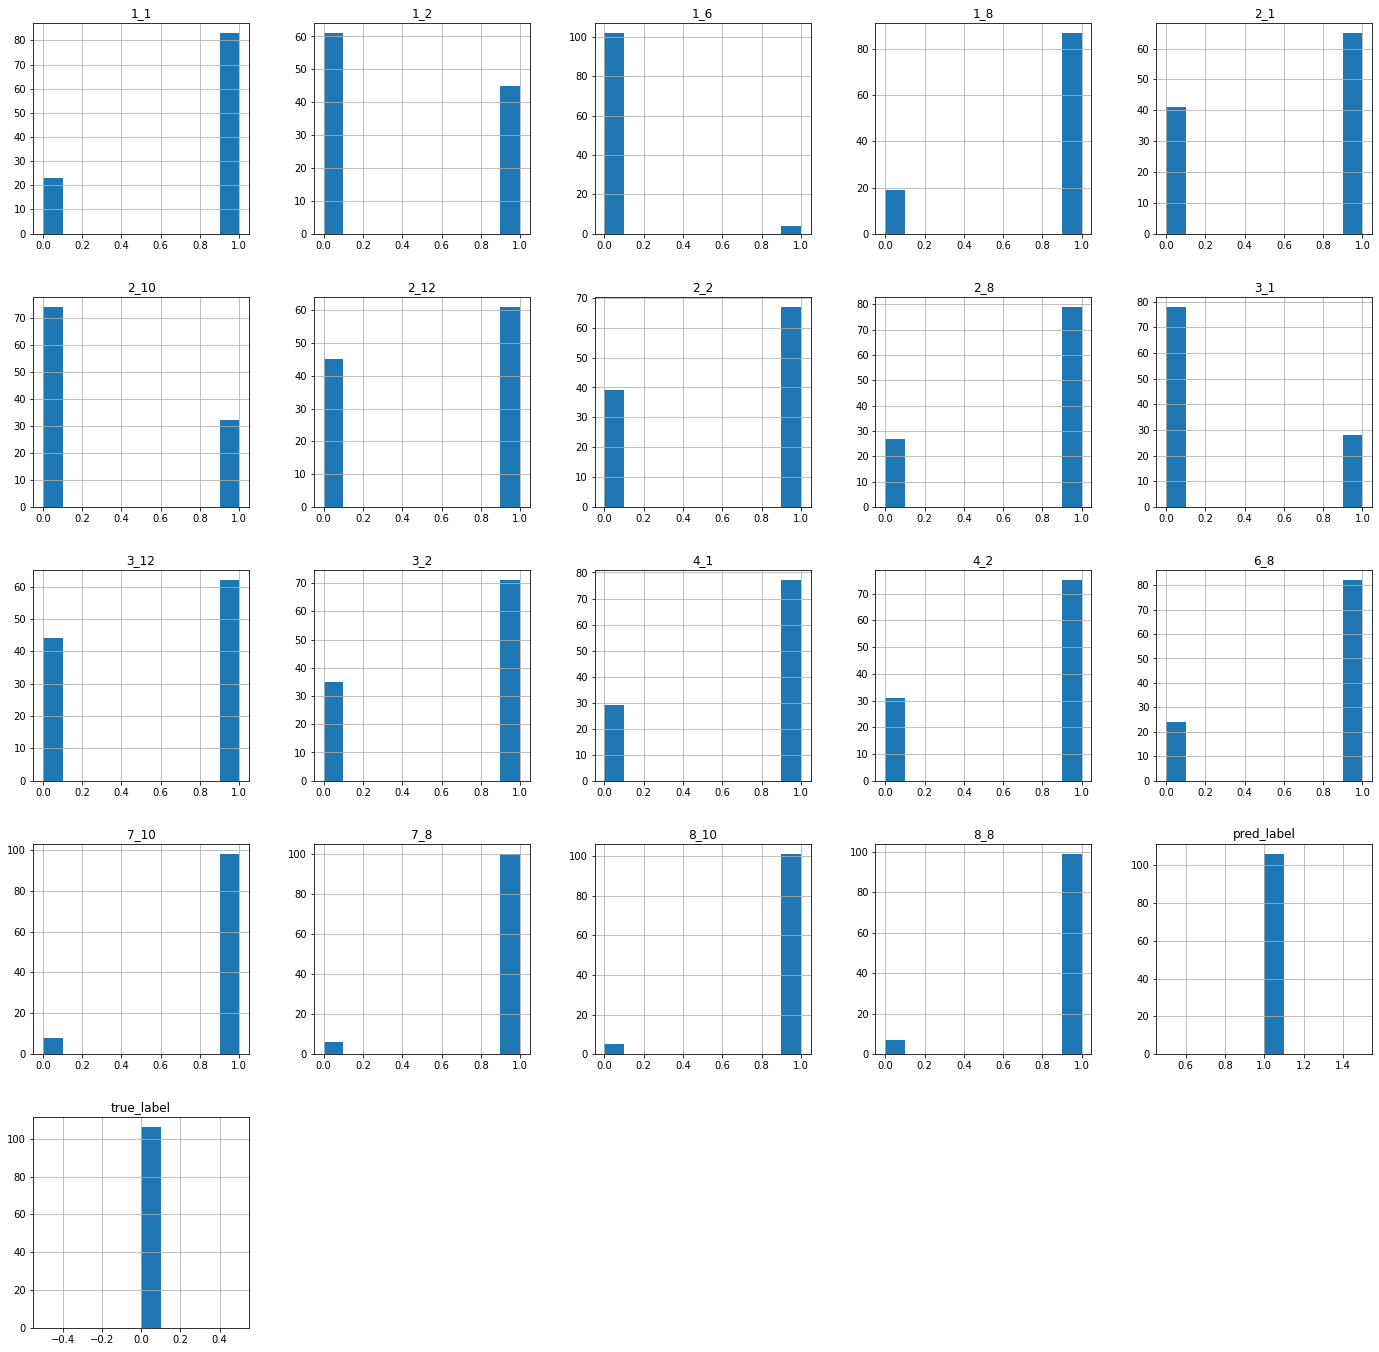

In [76]:
print_hist_models_predictions_fp(df_fp)

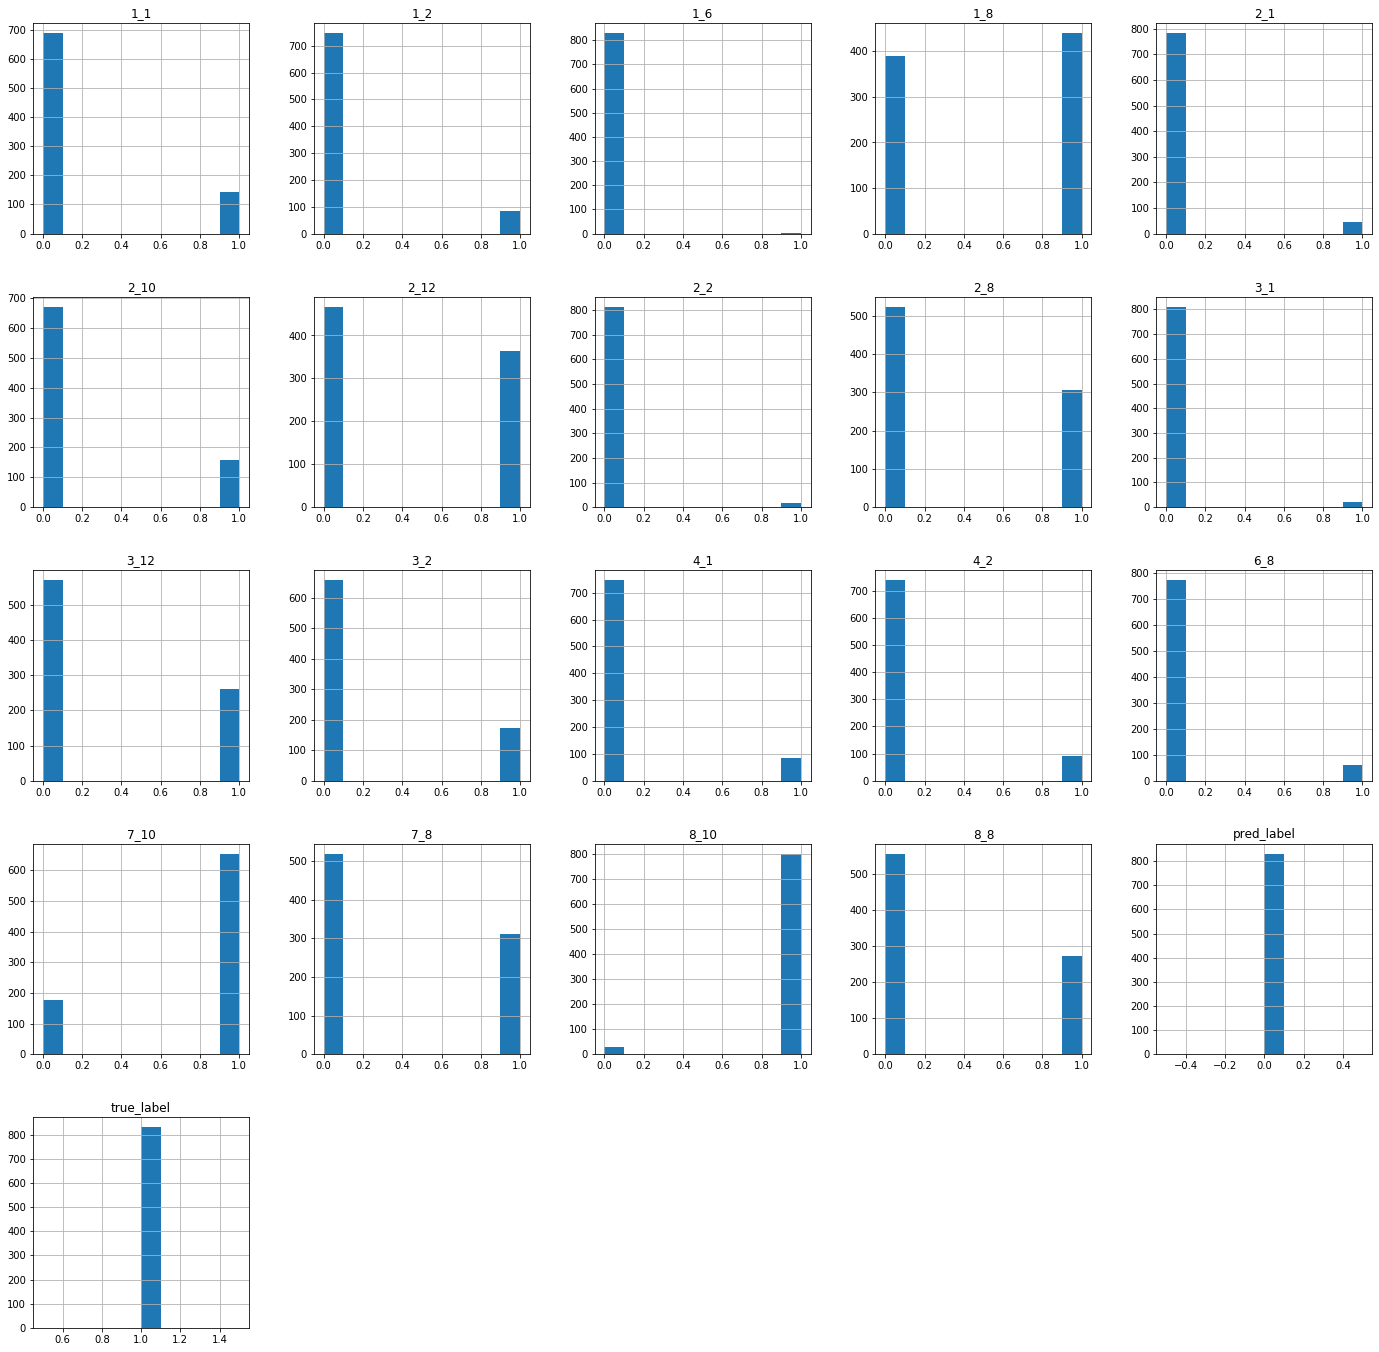

In [77]:
print_hist_models_predictions_fn(df_fn)

In [78]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.47      0.88      0.62       856
           1       0.75      0.27      0.40      1144

    accuracy                           0.53      2000
   macro avg       0.61      0.58      0.51      2000
weighted avg       0.63      0.53      0.49      2000



In [79]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/majority_validation_2_threshold_0.7.csv"
df_res.to_csv(csv_path)